In [1]:
!pip install pandas numpy plotly matplotlib seaborn --quiet

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'



# Clinical Terminology

Before jumping into the dataset, lets look at some basic definitions of the common clinical trial terminologies:

![](https://miro.medium.com/max/1400/1*gi_w8mUa3UmZFu86uOILBg.png)

For more information on Clinical Trials related glossary, refer to [this](https://clinicaltrials.gov/ct2/about-studies/glossary) and [this](https://medium.com/@gauravkantgoel/clinical-trials-glossary-6e1b4dc01e0d)

# 1. Exploratory Data Analysis (EDA) and Visualization

**Objective:** Understand the dataset's structure, identify patterns, detect anomalies, and check assumptions using statistical summaries and graphical representations.

In [3]:
train_df = pd.read_csv('/content/train_data.csv')
test_df = pd.read_csv('/content/test_data.csv')

In [ ]:
train_df.shape

(1053, 30)

In [ ]:
test_df.shape

(288, 29)

In [ ]:
train_df.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sponsor,Collaborators,Sex,Age,Phases,Enrollment,Funder Type,Study Type,Study Design,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,Outcome
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,NaN,AstraZeneca,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,713.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,05-07-14,02-13-17,08-24-23,04-29-14,01-30-19,10-10-23,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",Approved
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",NaN,Bristol-Myers Squibb,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,405.0,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,12-21-12,02-16-16,12-29-20,11-06-12,03-22-17,04-19-22,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,Approved


In [ ]:
test_df.head()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   nct_number                  1053 non-null   object 
 1   study_title                 1053 non-null   object 
 2   study_url                   1053 non-null   object 
 3   acronym                     533 non-null    object 
 4   study_status                1053 non-null   object 
 5   brief_summary               1053 non-null   object 
 6   study_results               1053 non-null   object 
 7   conditions                  1053 non-null   object 
 8   interventions               1053 non-null   object 
 9   primary_outcome_measures    1052 non-null   object 
 10  secondary_outcome_measures  997 non-null    object 
 11  other_outcome_measures      67 non-null     object 
 12  sponsor                     1053 non-null   object 
 13  collaborators               252 n

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   nct_number                  288 non-null    object
 1   study_title                 288 non-null    object
 2   study_url                   288 non-null    object
 3   acronym                     121 non-null    object
 4   study_status                288 non-null    object
 5   brief_summary               288 non-null    object
 6   study_results               288 non-null    object
 7   conditions                  288 non-null    object
 8   interventions               288 non-null    object
 9   primary_outcome_measures    288 non-null    object
 10  secondary_outcome_measures  275 non-null    object
 11  other_outcome_measures      20 non-null     object
 12  sponsor                     288 non-null    object
 13  collaborators               49 non-null     object

Lets rename these columns and follow snake casing

In [4]:
train_df.columns = train_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w_]', '', regex=True)

test_df.columns = test_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w_]', '', regex=True)


Explanation:
*   .str.strip() removes leading/trailing spaces.
*   .str.lower() makes all column names lowercase.
*   .str.replace(' ', '_') replaces spaces with underscores.
*   .str.replace(r'[^\w_]', '', regex=True) removes any non-alphanumeric characters (except underscore).



Example:
- Original column: "Primary Outcome Measures"
- Renamed column: "primary_outcome_measures"

In [ ]:
train_df.describe()

,Enrollment
count,1051.000000
mean,549.970504
std,454.162671
min,1.000000
25%,251.000000
50%,457.000000
75%,732.000000
max,4509.000000


In [ ]:
test_df.describe()

,Enrollment
count,288.000000
mean,714.416667
std,789.906698
min,20.000000
25%,363.000000
50%,543.500000
75%,800.000000
max,8000.000000


In [5]:
train_df.columns

Index(['nct_number', 'study_title', 'study_url', 'acronym', 'study_status',
       'brief_summary', 'study_results', 'conditions', 'interventions',
       'primary_outcome_measures', 'secondary_outcome_measures',
       'other_outcome_measures', 'sponsor', 'collaborators', 'sex', 'age',
       'phases', 'enrollment', 'funder_type', 'study_type', 'study_design',
       'start_date', 'primary_completion_date', 'completion_date',
       'first_posted', 'results_first_posted', 'last_update_posted',
       'locations', 'study_documents', 'outcome'],
      dtype='object')

| **Column Name**              | **Description**                                                                                                               |      |
| ---------------------------- | ----------------------------------------------------------------------------------------------------------------------------- | ---- |
| `NCT Number`                 | Unique identifier for the clinical trial (assigned by ClinicalTrials.gov), e.g., `NCT02125461`.                               |      |
| `Study Title`                | Official title of the clinical trial, usually technical and descriptive of the study's purpose.                               |      |
| `Study URL`                  | Direct URL to the trial's page on ClinicalTrials.gov.                                                                         |      |
| `Acronym`                    | Short abbreviation for the study (if available), e.g., `PACIFIC`.                                                             |      |
| `Study Status`               | The current state of the trial (e.g., `Completed`, `Active`, `Recruiting`, `Terminated`, `Withdrawn`).                        |      |
| `Brief Summary`              | A short paragraph summarizing the study's intent, design, and treatment approach. Often extracted from the protocol.          |      |
| `Study Results`              | Indicates if results are available (`YES`/`NO`) on ClinicalTrials.gov.                                                        |      |
| `Conditions`                 | Diseases, disorders, or health conditions being studied. Usually standardized terms like `Non-Small Cell Lung Cancer`.        |      |
| `Interventions`              | The treatments, drugs, procedures, or placebos used in the study (can be multiple, delimited by \`                            | \`). |
| `Primary Outcome Measures`   | Key outcomes that determine the effectiveness/safety of the intervention (e.g., `Progression-Free Survival`).                 |      |
| `Secondary Outcome Measures` | Additional outcomes of interest (e.g., `Overall Survival`, `Quality of Life`), not primary endpoints.                         |      |
| `Other Outcome Measures`     | Exploratory or less critical outcomes measured in the study.                                                                  |      |
| `Sponsor`                    | Primary organization responsible for conducting the study (often a pharma company, academic institute, or government agency). |      |
| `Collaborators`              | Other organizations or partners involved in the trial.                                                                        |      |
| `Sex`                        | Participant eligibility by gender: `ALL`, `MALE`, `FEMALE`.                                                                   |      |
| `Age`                        | Participant eligibility by age group: e.g., `ADULT`, `CHILD`, `OLDER_ADULT`, or a combination.                                |      |
| `Phases`                     | Clinical trial phase, such as `PHASE1`, `PHASE2`, `PHASE3`, etc. (some trials span multiple phases).                          |      |
| `Enrollment`                 | Target or actual number of participants in the study.                                                                         |      |
| `Funder Type`                | Entity type funding the trial: e.g., `INDUSTRY`, `NIH`, `OTHER`.                                                              |      |
| `Study Type`                 | Type of trial: `INTERVENTIONAL`, `OBSERVATIONAL`, or `EXPANDED ACCESS`.                                                       |      |
| `Study Design`               | Concatenated description of the study’s methodology: e.g., randomization, blinding, intervention model, and primary purpose.  |      |
| `Start Date`                 | Date when the trial officially started recruiting participants.                                                               |      |
| `Primary Completion Date`    | Date when data collection for the primary outcome measure was completed.                                                      |      |
| `Completion Date`            | Date when the trial was fully completed (including secondary outcomes and final data).                                        |      |
| `First Posted`               | When the trial was first registered/listed on ClinicalTrials.gov.                                                             |      |
| `Results First Posted`       | Date when the trial results were first posted (if applicable).                                                                |      |
| `Last Update Posted`         | Most recent update to the trial information.                                                                                  |      |
| `Locations`                  | List of cities/countries where the trial was conducted. Can be extensive for global trials.                                   |      |
| `Study Documents`            | Links to downloadable trial documentation, like protocol PDFs, statistical analysis plans, etc.                               |      |


## Missing value analysis

In [6]:
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

,0
other_outcome_measures,986
collaborators,801
acronym,520
study_documents,471
results_first_posted,246
secondary_outcome_measures,56
locations,36
completion_date,5
primary_completion_date,2
enrollment,2


In [7]:
missing_values = test_df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

,0
results_first_posted,285
study_documents,285
other_outcome_measures,268
collaborators,239
acronym,167
locations,19
secondary_outcome_measures,13


Text(0.5, 1.0, 'Features with >1% missing data')

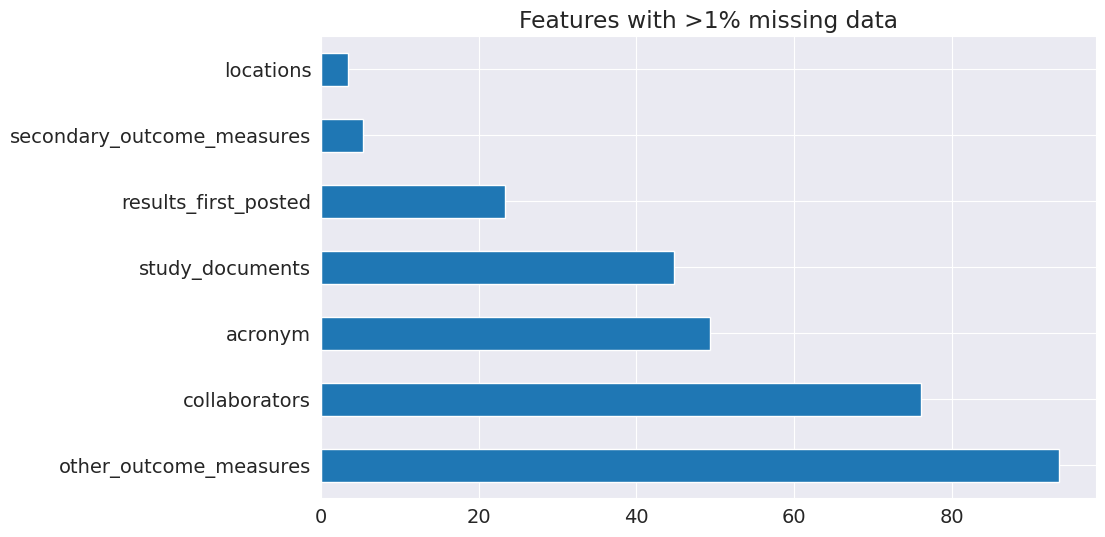

In [ ]:
missing = train_df.isnull().mean().sort_values(ascending=False)*100
missing[missing > 1].plot(kind='barh')
plt.title("Features with >1% missing data")

Text(0.5, 1.0, 'Features with >1% missing data')

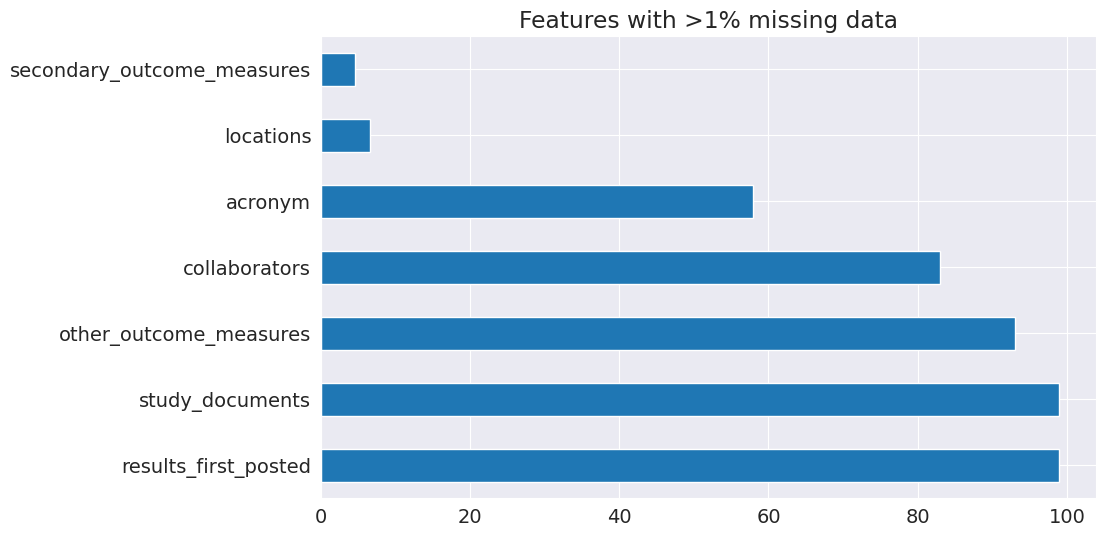

In [ ]:
missing = test_df.isnull().mean().sort_values(ascending=False)*100
missing[missing > 1].plot(kind='barh')
plt.title("Features with >1% missing data")

Most missingness is concentrated in:

- Other Outcome Measures (~90%)

- Collaborators (~75%)

- Acronym, Study Documents, Results First Posted (~20–40%)

Implications:
- Actionable strategy per field:

 - Other Outcome Measures: likely ignorable or use a binary flag (has_other_outcomes)

 - Collaborators: flag or impute as "None" if truly empty

 - Acronym: non-essential, drop

 - Study Documents: can be used as a proxy for transparency (binary: has docs)

 - Results First Posted: binary (has_results_posted) may be predictive of outcome maturity

## Data Visualization

Lets try visualizing all the columns and how they are related to target column.



```
# Histogram for numerical features
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

#histogram for categorical features
px.histogram(raw_df, x='column', title='column vs. target', color='target')

```

### Temporal trends
Lets try to visualize both training and test dataset to understand how trials are distributed with respect to year

**Training dataset**

In [20]:
# Create histogram
fig = px.histogram(train_df, x=pd.to_datetime(train_df['start_date'], format='mixed', errors='coerce').dt.year, title='No. of Rows per Year train dataset')
# Add space between bars
fig.update_layout(bargap=0.2)
fig.show()

**Test dataset**

In [19]:
# Create histogram
fig = px.histogram(test_df, x=pd.to_datetime(test_df['start_date'], format='mixed', errors='coerce').dt.year, title='No. of Rows per Year test dataset')
# Add space between bars
fig.update_layout(bargap=0.2)
fig.show()

**Insight:**

**Train Dataset**
- Covers a broad range: ~2000 to 2024

- Highly imbalanced over time:

- Sparse data from 2000–2009

- Sharp rise from 2010

- Peak around 2014–2017

- Gradual decline after 2018

**Test Dataset**
- Mostly includes data from 2018 to 2025

- Very recent-heavy, no older data before ~2014

- Distribution skews heavily toward newer years (esp. post-2020)

**Random splits** would leak temporal patterns and invalidate the evaluation.

**Temporal Split Strategy**

We can Split train data based on time to simulate future unseen data:

- Training:     Data before ~2018
- Validation:   Data from ~2018 to 2022
- Testing:      Provided test set (2023–2025+)

In [21]:
full_data = train_df.copy()

In [29]:
full_data['start_year'] = pd.to_datetime(full_data['start_date'], format='mixed', errors='coerce').dt.year
train_df = full_data[full_data['start_year'] < 2018]
val_df = full_data[(full_data['start_year'] >= 2020) & (full_data['start_year'] < 2022)]
test_df = full_data[full_data['start_year'] >= 2022]

In [30]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (698, 32)
val_df.shape : (132, 32)
test_df.shape : (46, 32)


This looks balanced we can work with this

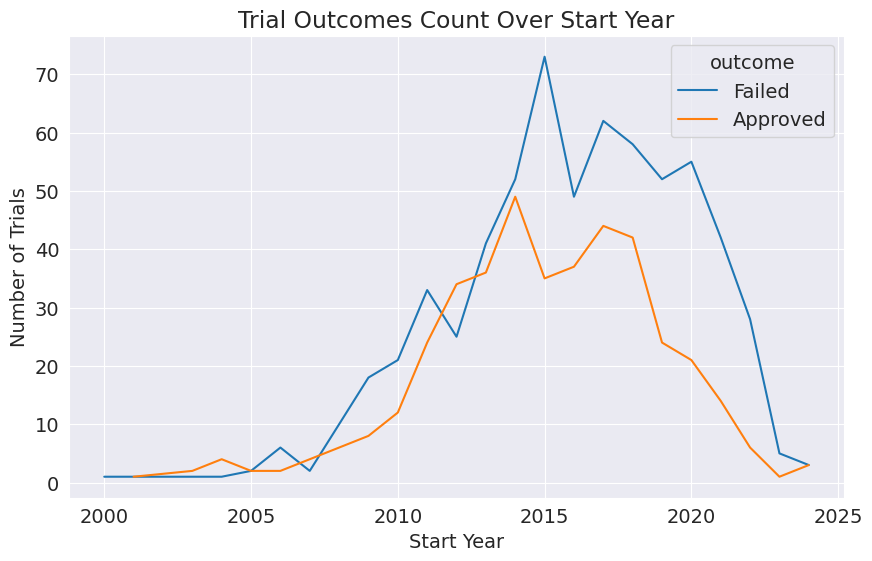

In [25]:
# Drop rows where 'Start Year' could not be extracted (NaN)
df_hist = full_data.dropna(subset=['start_year'])

# Group by 'Start Year' and 'Outcome' and count the occurrences
outcome_counts_by_year = df_hist.groupby(['start_year', 'outcome']).size().reset_index(name='Count')

# Plot the counts over time using seaborn.lineplot
# 'Start Year' is on the x-axis and the computed 'Count' is on the y-axis,
# with lines separated by 'Outcome'.
sns.lineplot(data=outcome_counts_by_year, x='start_year', y='Count', hue='outcome')
plt.title('Trial Outcomes Count Over Start Year')
plt.ylabel('Number of Trials')
plt.xlabel('Start Year')
plt.show()

Insight:
- Sharp increase in trials post-2010, peaking between 2015–2019.

- Both approvals and failures follow similar growth, but failures consistently outnumber approvals.

- Post-2020 drop is likely due to data lag — many recent trials may still be ongoing.

Implications:
- For modeling: trials started in recent years may not have complete outcomes → risk of label leakage or incomplete supervision.

- Possible feature idea: trial age or duration as proxy for maturity.

- We should Consider excluding trials started after 2020 if many are censored or mislabeled.

### Study Type vs Approval

In [31]:
train_df['study_type'].value_counts()

,count
study_type,
INTERVENTIONAL,698


In [36]:
px.histogram(train_df, x='study_type', title='Study Type vs. target', color='outcome')

- There is 40% positive approvals and 60% failed trials which is the overall approval rate in training data there isn't any other category so we can drop this column.
- All study type are interventional we dont see any relation hence it can be dropped.

### Overall Approval Rate

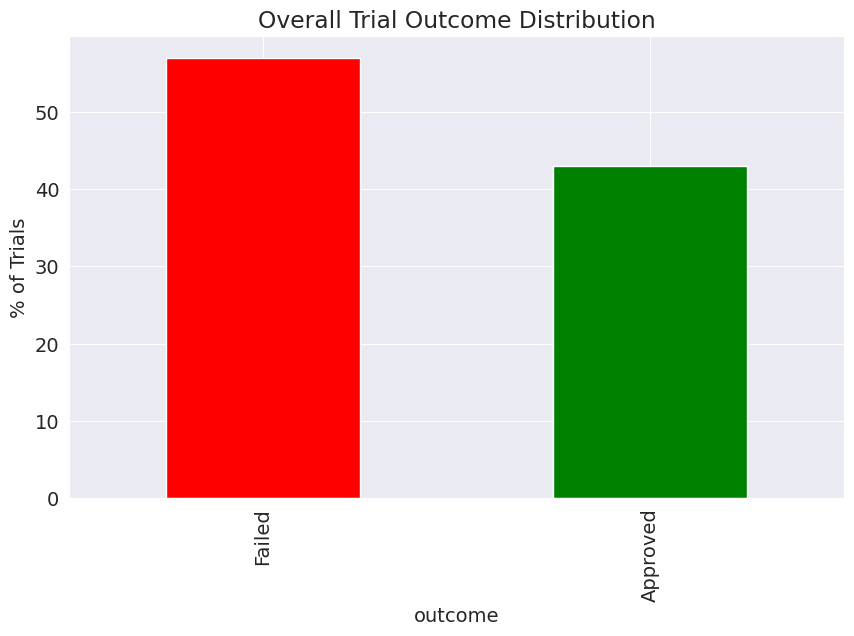

In [37]:
approved_pct = train_df['outcome'].value_counts(normalize=True) * 100
approved_pct.plot(kind='bar', color=['red', 'green'])
plt.title("Overall Trial Outcome Distribution")
plt.ylabel("% of Trials")
plt.show()

Insight:

Around 60% of historical trials failed, and only 40% succeeded.

This highlights a class imbalance, which is typical in real-world clinical trial data.

Implications:

Modeling will need to account for imbalance — need to use metrics like ROC AUC, precision/recall, or calibrated probabilities.

Can’t rely solely on accuracy; a naive model predicting “fail” for all trials would be 60% accurate but useless.

> Why Imbalanced Data is a Problem?

When one class dominates (e.g., Failures), a model can get high accuracy by doing almost nothing:

**Example:**

> Imagine a dumb model that always predicts "Fail":


Accuracy = 60% — just by predicting the majority class

But it never detects successful trials (the actual valuable cases!)

So this model is useless in practice, even though accuracy seems “good”

**Why These Metrics Are Better:**
1. ROC AUC (Area Under Curve)
Measures how well the model separates approved vs. failed trials

 -  Insensitive to class imbalance

 -  0.5 = random guess, 1.0 = perfect separation

2. Precision / Recall / F1
 - Focus on true positive quality

 - Important when false negatives (missing good drugs) or false positives (approving bad ones) are costly

| Metric    | What It Tells You                        |
| --------- | ---------------------------------------- |
| Precision | When model says “Approved,” is it right? |
| Recall    | Of all true “Approved,” how many found?  |
| F1 Score  | Balance between Precision & Recall       |


**Why Calibrated Probabilities?**
We’ll be using the predicted probabilities as PTS scores

If model is overconfident or underconfident, the PTS % won’t be meaningful

Calibrated classifiers ensure the predicted probability = real-world likelihood

> For example:

If the model assigns 80% PTS to 100 trials, about 80 of them should really succeed.

This is crucial in risk-based decision-making in clinical development.

### Trial outcome vs Phase

In [42]:
train_df['phases'].value_counts()

,count
phases,
PHASE3,694
PHASE2|PHASE3,3
PHASE2,1


In [43]:
val_df['phases'].value_counts()

,count
phases,
PHASE3,131
PHASE2|PHASE3,1


In [44]:
test_df['phases'].value_counts()

,count
phases,
PHASE3,46


In [41]:
import plotly.express as px

fig = px.bar(
    train_df,
    x='phases',
    color='outcome',
    title='Trial Outcome Counts by Phase',
    color_discrete_map={'Approved': 'green', 'Failed': 'red'},
    barmode='group',  # Use 'group' if you want side-by-side bars
)

fig.update_layout(
    xaxis_title='Phase',
    yaxis_title='Number of Trials',
    legend_title='Trial Outcome',
    bargap=0.2
)

fig.show()


Insight:

- There are almost 99% phase 3 trials in training dataset, val and test setts
- lets just skip other classes and can drop this column.


### Top Sponsors vs outcome

In [48]:
train_df['sponsor'].value_counts().nlargest(20)

,count
sponsor,
Hoffmann-La Roche,62
Novartis Pharmaceuticals,46
AstraZeneca,41
Bristol-Myers Squibb,41
Merck Sharp & Dohme LLC,28
"Janssen Research & Development, LLC",24
Pfizer,21
Amgen,17
AbbVie,16


Sorted Plotly Histogram by Total Trials per Sponsor

In [59]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['sponsor']
    .value_counts()
    .nlargest(10)
    .index
)

# Step 2: Filter and order data
df_top = train_df[train_df['sponsor'].isin(top_sponsors)]
sponsor_order = (
    df_top['sponsor']
    .value_counts()
    .loc[top_sponsors]
    .index.tolist()
)

# Step 3: Plot sorted histogram
fig = px.histogram(
    df_top,
    x='sponsor',
    color='outcome',
    barmode='group',
    title='Trial Outcome Count by Top 10 Sponsors (Sorted)',
    category_orders={'sponsor': sponsor_order}
)

fig.update_layout(
    xaxis_title='Sponsor',
    yaxis_title='Number of Trials',
    bargap=0.2
)

fig.show()

**Normalized Outcome Distribution per Sponsor(share of success/failure per sponsor.)**

In [63]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['sponsor']
    .value_counts()
    .nlargest(10)
    .index
)

# Step 2: Filter and order data
df_top = train_df[train_df['sponsor'].isin(top_sponsors)]
sponsor_order = (
    df_top['sponsor']
    .value_counts()
    .loc[top_sponsors]
    .index.tolist()
)

# Step 3: Plot sorted histogram
fig = px.histogram(
    df_top,
    x='sponsor',
    color='outcome',
    barmode='stack',
    barnorm='percent',
    title='Normalized Outcome Distribution per Sponsor(share of success/failure per sponsor.)',
    category_orders={'sponsor': sponsor_order}
)

fig.update_layout(
    xaxis_title='Sponsor',
    yaxis_title='Number of Trials',
    bargap=0.2
)

fig.show()

 **Observations**

1. **Hoffmann-La Roche**:

   * Has the **highest number of total trials**.
   * **More failures** than approvals → success rate may be lower than average.

2. **Novartis Pharmaceuticals**:

   * Fairly **balanced outcome distribution**, with slightly more approvals than failures.
   * Strong performance relative to its trial volume.

3. **AstraZeneca & Bristol-Myers Squibb**:

   * Similar number of trials and outcomes.
   * **Moderate success rate**—neither clearly dominant nor underperforming.

4. **Merck, Janssen, Pfizer**:

   * Each has fewer trials than the top 3, but **Pfizer and Janssen** show a **higher proportion of approvals**.
   * This might suggest **greater efficiency or selectivity** in the trials they run.

5. **Amgen, AbbVie, Eli Lilly**:

   * Fewer trials overall.
   * Approvals and failures are quite close in number, with **Eli Lilly having a slightly better ratio**.

**Implications**

* **Trial Efficiency**:

  * Sponsors like **Pfizer and Janssen** may be achieving higher **success rates per trial**. Their **smaller trial count** but relatively strong approvals suggest **more effective trial design** or **better candidate selection**.

* **Hoffmann-La Roche**:

  * Their high number of failures may warrant deeper investigation — perhaps due to **higher trial risk appetite**, focus on **challenging therapeutic areas**, or **aggressive pipeline strategy**.

* **Sponsor Strategy Segmentation**:

  * Consider grouping sponsors by their **approval ratio** instead of just trial count, for better performance assessment.



We can try generating some more visuals like:
- Approval Rate per Sponsor – a bar chart showing percentage of approvals.

- Number of Trials Over Time per Sponsor – to capture sponsor activity trends.


In [74]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    train_df['sponsor']
    .value_counts()
    .nlargest(10)
    .index
)

# Step 2: Filter to top sponsors
df_top = train_df[train_df['sponsor'].isin(top_sponsors)]

# Step 3: Group by sponsor and outcome
outcome_counts = (
    df_top
    .groupby(['sponsor', 'outcome'])
    .size()
    .unstack(fill_value=0)
)

# Optional: Ensure consistent column naming
outcome_counts = outcome_counts.rename(columns=lambda x: str(x).lower())

# Step 4: Compute success rate
# Assuming 'approved' and 'failed' are the only outcomes (adjust names if different)
outcome_counts['success_rate'] = outcome_counts['approved'] / (outcome_counts['approved'] + outcome_counts['failed'])

# Step 5: Reset index if needed
success_rate_df = outcome_counts[['success_rate']].reset_index()

# Display the result
print(success_rate_df)


outcome                              sponsor  success_rate
0                                     AbbVie      0.375000
1                                      Amgen      0.411765
2                                AstraZeneca      0.463415
3                       Bristol-Myers Squibb      0.463415
4                      Eli Lilly and Company      0.642857
5                          Hoffmann-La Roche      0.306452
6        Janssen Research & Development, LLC      0.708333
7                    Merck Sharp & Dohme LLC      0.571429
8                   Novartis Pharmaceuticals      0.521739
9                                     Pfizer      0.666667


In [75]:
px.bar(success_rate_df, x='sponsor', y='success_rate')

Janssen has highest approval rate of around 70 % followed by pfizer 66% then lily 64% and then merck 57% and novartis 52%.

Roche has lowest approval rate 30%

This is really helpful lets just create a sponsor approval rate dataset on full data that we can use later in feature engineering.**bold text**

In [71]:
# Step 1: Get top sponsors sorted by total count
top_sponsors = (
    full_data['sponsor']
    .value_counts()
    .index
)

# Step 2: Filter to top sponsors
df_top = full_data[full_data['sponsor'].isin(top_sponsors)]

# Step 1: Group by sponsor and outcome
outcome_counts = (
    df_top
    .groupby(['sponsor', 'outcome'])
    .size()
    .unstack(fill_value=0)
)

# Optional: Ensure consistent column naming
outcome_counts = outcome_counts.rename(columns=lambda x: str(x).lower())

# Step 4: Compute success rate
# Assuming 'approved' and 'failed' are the only outcomes (adjust names if different)
outcome_counts['success_rate'] = outcome_counts['approved'] / (outcome_counts['approved'] + outcome_counts['failed'])

# Step 5: Reset index if needed
success_rate_df = outcome_counts[['success_rate']].reset_index()

# Display the result
print(success_rate_df)


outcome                                            sponsor  success_rate
0                                               AB Science      0.000000
1                              ACADIA Pharmaceuticals Inc.      0.333333
2                                         AEterna Zentaris      0.000000
3                                     AGC Biologics S.p.A.      0.000000
4                          ALK-AbellÃƒÆ’Ã†â€™Ãƒâ€šÃ‚Â³ A/S      0.000000
..                                                     ...           ...
282                                              Veru Inc.      0.000000
283                                 Xcovery Holdings, Inc.      1.000000
284      Zogenix International Limited, Inc., a subsidi...      1.000000
285                                             medac GmbH      1.000000
286                                         pharmaand GmbH      0.333333

[287 rows x 2 columns]


In [72]:
#finally write it to a dataset to use later
success_rate_df.to_csv("/content/sponsor_approval_rate.csv", index=False)

### Approval % by Top 10 Conditions

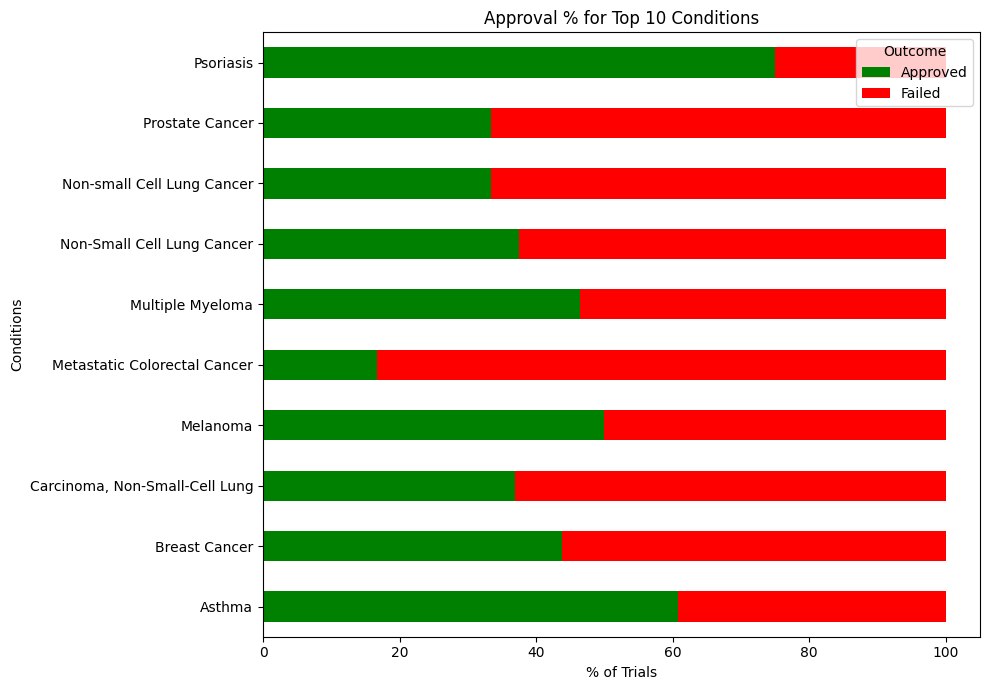

In [ ]:
# Get top 10 conditions
top_conditions = train_df['Conditions'].value_counts().nlargest(10).index

# Filter
df_top_cond = train_df[train_df['Conditions'].isin(top_conditions)]

# Group and plot
cond_group = df_top_cond.groupby('Conditions')['Outcome'].value_counts(normalize=True).unstack().fillna(0) * 100

cond_group.plot(kind='barh', stacked=True, figsize=(10, 7), color=['green', 'red'])
plt.title("Approval % for Top 10 Conditions")
plt.xlabel("% of Trials")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()


Insight:

There's significant variance in approval rates by condition:

Psoriasis, Asthma, and Multiple Myeloma show higher approval (~50–70%).

Colorectal Cancer, Melanoma, and NSCLC show lower approval (~10–30%).

Some condition names are duplicated with variations (e.g., Non-Small Cell Lung Cancer vs. Non-small Cell Lung Cancer vs. Carcinoma, Non-Small-Cell Lung).

Implications:

Therapeutic Area (TA) or condition is a strong predictor of trial success.

Normalize similar condition names (e.g., by stemming, or ICD mapping).

We could engineer a condition-level baseline approval rate as a feature.

May be useful to group conditions into high-risk vs. low-risk or by therapeutic domain.

In [ ]:
# import the necessary libraries
import numpy as np
import pandas as pd
import os
from xml.etree import ElementTree

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
!pip install chart_studio
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
#py.init_notebook_mode(connected=True)

#Geographical Plotting
import folium
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

#Racing Bar Chart
!pip install bar_chart_race
import bar_chart_race as bcr
from IPython.display import HTML

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")# for pretty graphs

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

### Enrollment Distribution

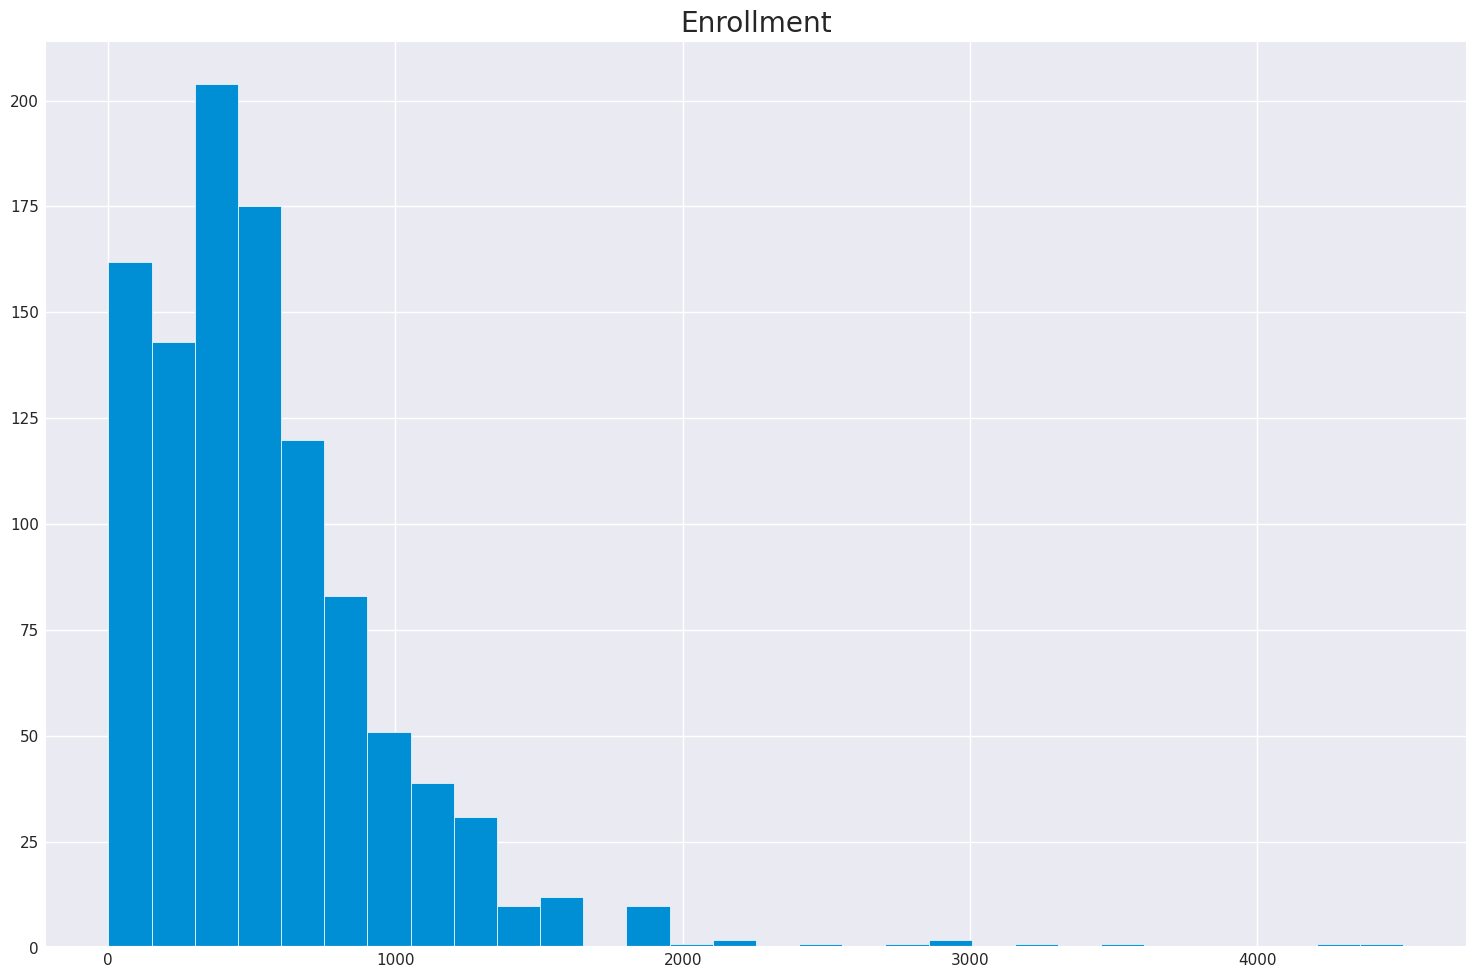

In [ ]:
train_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

## Study status Analysis
Study status can be either of the following:
-   **Not yet recruiting:**  The study has not started recruiting participants.
-   **Recruiting:**  The study is currently recruiting participants.
-   **Enrolling by invitation:**  The study is selecting its participants from a population, or group of people, decided on by the researchers in advance. These studies are not open to everyone who meets the eligibility criteria but only to people in that particular population, who are specifically invited to participate.
-   **Active, not recruiting:**  The study is ongoing, and participants are receiving an intervention or being examined, but potential participants are not currently being recruited or enrolled.
-   **Suspended:**  The study has stopped early but may start again.
-   **Terminated:**  The study has stopped early and will not start again. Participants are no longer being examined or treated.
-   **Completed:**  The study has ended normally, and participants are no longer being examined or treated (that is, the last participant's last visit has occurred).
-   **Withdrawn:**  The study stopped early, before enrolling its first participant.
-   **Unknown:**  A study on ClinicalTrials.gov whose last known status was recruiting; not yet recruiting; or active, not recruiting but that has passed its completion date, and the status has not been  last verified  within the past 2 years.

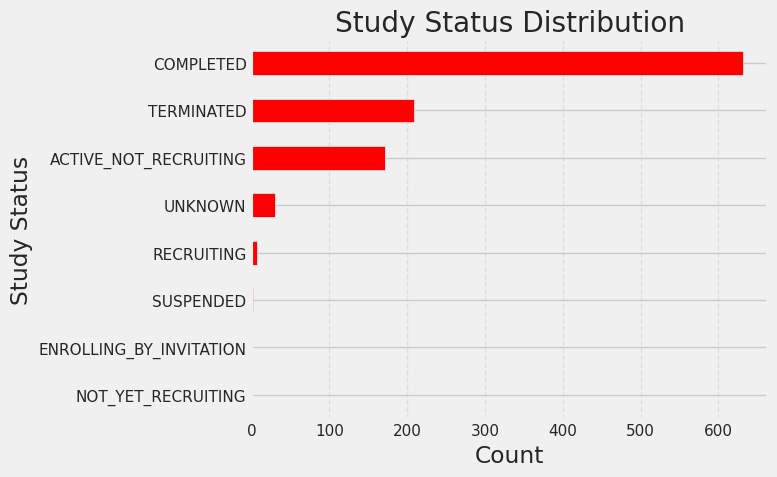

In [ ]:
train_df_filtered['Study Status'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

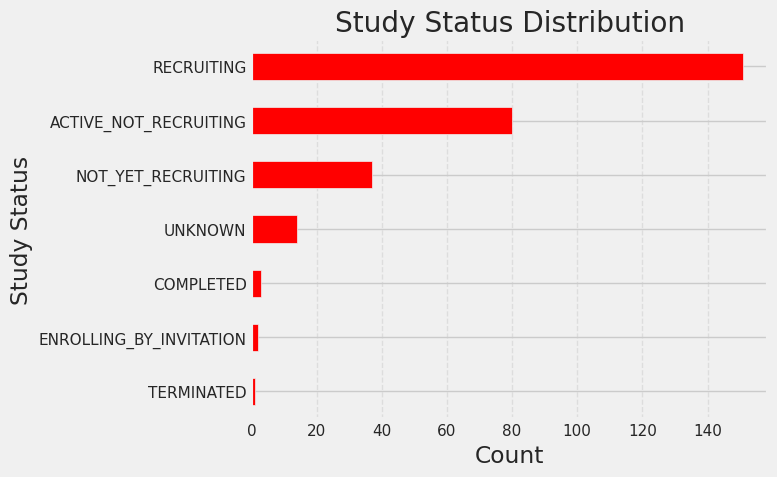

In [ ]:
test_df_filtered['Study Status'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

There seems to be alot of completed studies in training dataset whereas we have very few in test.
most of the active clinical trials are recruiting, active_not_recrutiting or not_yet_recruiting.

## Study Types

Describes the nature of a clinical study. Study types include :

### Interventional studies (also called clinical trials),

A type of clinical study in which participants are assigned to groups that receive one or more intervention/treatment (or no intervention) so that researchers can evaluate the effects of the interventions on biomedical or health-related outcomes. The assignments are determined by the study's protocol. Participants may receive diagnostic, therapeutic, or other types of interventions.


### Observational studies (including patient registries),

A type of clinical study in which participants are identified as belonging to study groups and are assessed for biomedical or health outcomes. Participants may receive diagnostic, therapeutic, or other types of interventions, but the investigator does not assign participants to a specific interventions/treatment.
A patient registry is a type of observational study.

### Expanded access.

A way for patients with serious diseases or conditions who cannot participate in a clinical trial to gain access to a medical product that has not been approved by the U.S. Food and Drug Administration (FDA). Also called compassionate use. There are different expanded access types.

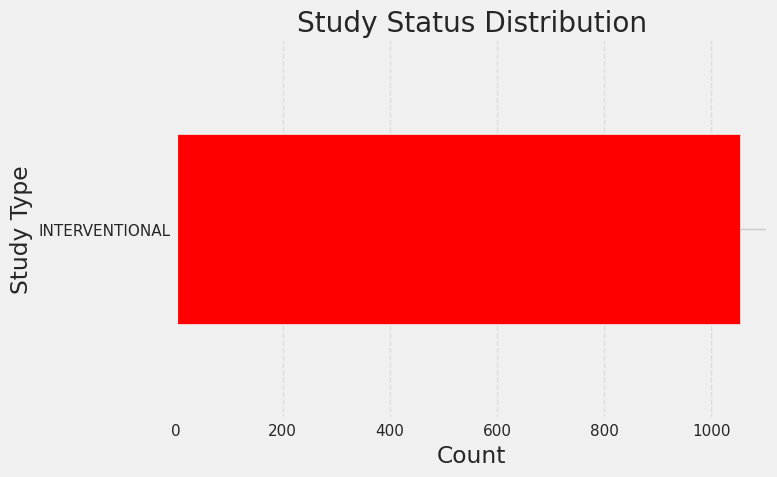

In [ ]:
train_df_filtered['Study Type'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

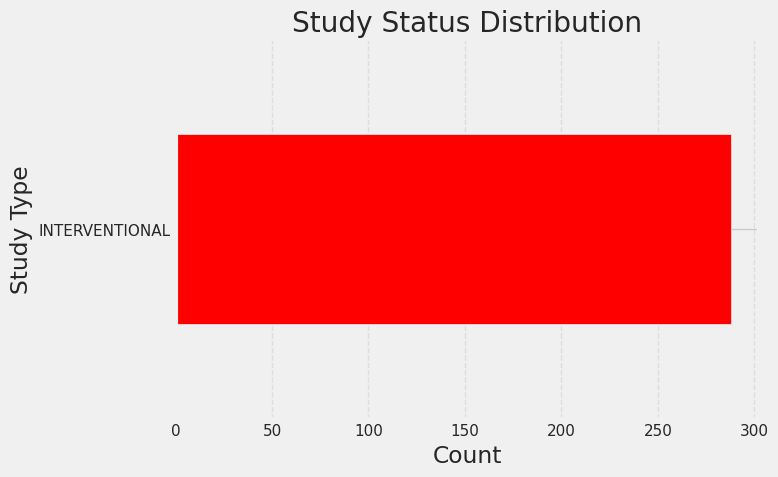

In [ ]:
test_df_filtered['Study Type'].value_counts().sort_values().plot.barh(
    color='red',
    figsize=(8, 5),
    title='Study Status Distribution'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

All of these are Interventional study type there aren't any other groups so we can drop this column as it wont have any effect on predictions.

## Interventions given

Intervention refers to the medicinal product (e.g drug, device, vaccine, placebo etc) given to the patients in a study. Let’s see the top five interventions given in these studies.

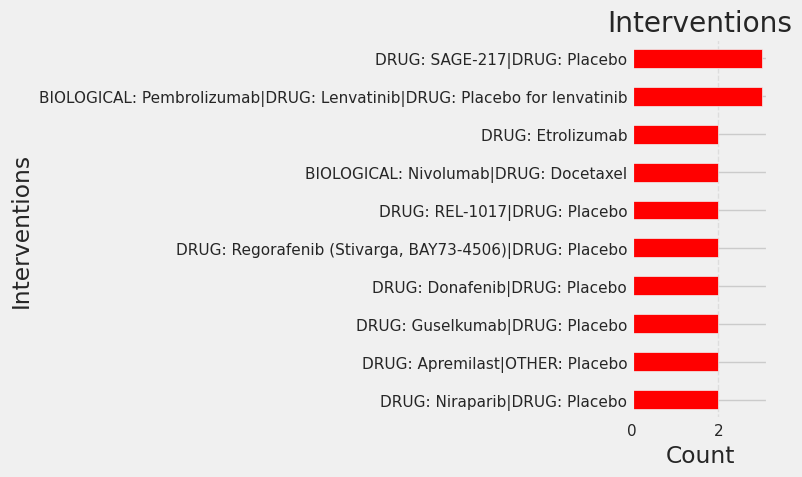

In [ ]:
interventional_studies = train_df_filtered[train_df_filtered['Study Type']=='INTERVENTIONAL']
top_interventions = interventional_studies['Interventions'].value_counts().sort_values(ascending=True)[-10:]
top_interventions.plot.barh(
    color='red',
    title='Interventions'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
top_interventions

,count
Interventions,
DRUG: Niraparib|DRUG: Placebo,2
DRUG: Apremilast|OTHER: Placebo,2
DRUG: Guselkumab|DRUG: Placebo,2
DRUG: Donafenib|DRUG: Placebo,2
"DRUG: Regorafenib (Stivarga, BAY73-4506)|DRUG: Placebo",2
DRUG: REL-1017|DRUG: Placebo,2
BIOLOGICAL: Nivolumab|DRUG: Docetaxel,2
DRUG: Etrolizumab,2
BIOLOGICAL: Pembrolizumab|DRUG: Lenvatinib|DRUG: Placebo for lenvatinib,3


Interventions has lot of unstructure data its better we split this data into multiple categorical columns and do one hot encoding on it.

## Sponsors

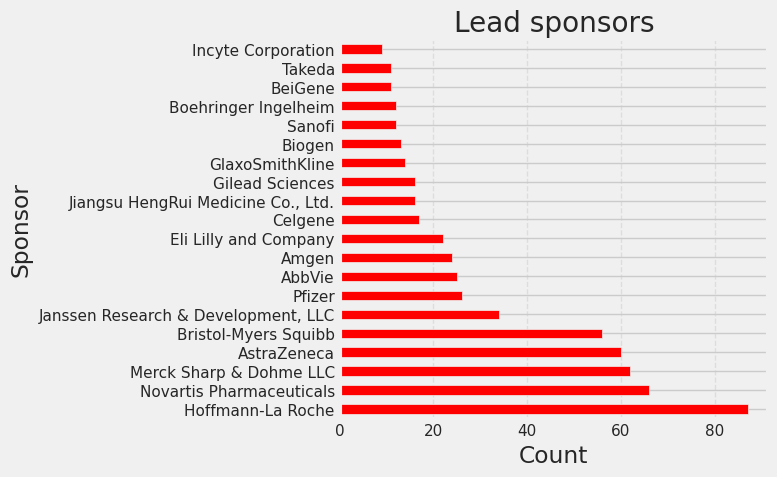

In [ ]:
lead_sponsors = interventional_studies['Sponsor'].value_counts().sort_values(ascending=False)[:20]
lead_sponsors.plot.barh(
    color='red',
    title='Lead sponsors'
  )
plt.xlabel('Count')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
lead_sponsors

,count
Sponsor,
Hoffmann-La Roche,87
Novartis Pharmaceuticals,66
Merck Sharp & Dohme LLC,62
AstraZeneca,60
Bristol-Myers Squibb,56
"Janssen Research & Development, LLC",34
Pfizer,26
AbbVie,25
Amgen,24


# Feature Engineering

In [ ]:
feature_engineered_df = train_df.copy()

Features:
Index(['NCT Number', 'Study Title', 'Study URL', 'Acronym', 'Study Status',
       'Brief Summary', 'Study Results', 'Conditions', 'Interventions',
       'Primary Outcome Measures', 'Secondary Outcome Measures',
       'Other Outcome Measures', 'Sponsor', 'Collaborators', 'Sex', 'Age',
       'Phases', 'Enrollment', 'Funder Type', 'Study Type', 'Study Design',
       'Start Date', 'Primary Completion Date', 'Completion Date',
       'First Posted', 'Results First Posted', 'Last Update Posted',
       'Locations', 'Study Documents', 'Outcome'],
      dtype='object')

## Timeline Features

In [ ]:
def parse_dates(df, date_cols):
    """
    Convert date columns to datetime and compute derived durations.
    date_cols: dict mapping new feature names to tuple(original_col, ref_col)
    e.g., { 'duration_days': ('StartDate', 'CompletionDate') }
    """
    for feat, (col1, col2) in date_cols.items():
        df[col1] = pd.to_datetime(df[col1], errors='coerce')
        df[col2] = pd.to_datetime(df[col2], errors='coerce')
        df[feat] = (df[col2] - df[col1]).dt.days
    # Extract year/month for StartDate
    df['start_year'] = df['StartDate'].dt.year
    df['start_month'] = df['StartDate'].dt.month
    return df

In [ ]:
date_cols = {
    'duration_days': ('StartDate', 'CompletionDate'),
    'time_to_primary_days': ('StartDate', 'PrimaryCompletionDate'),
    'time_to_start': ('StartDate', 'FirstPosted'),
    'time_to_results': ('StartDate', 'ResultsFirstPosted'),
    'time_to_last_update': ('StartDate', 'LastUpdatePosted')
}
df = parse_dates(df, date_cols)

In [ ]:
def create_date_features(df: pd.DataFrame) -> pd.DataFrame:
        """Create date-based features"""

        # Convert dates
        date_columns = [ 'Start Date', 'Primary Completion Date', 'Completion Date',
                        'First Posted', 'Results First Posted', 'Last Update Posted']

        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')

        # Study duration
        df['StudyDuration'] = (df['Completion Date'] - df['Start Date']).dt.days
        df['StudyDuration'] = df['StudyDuration'].fillna(df['StudyDuration'].median())

        # Time to start from submission
        df['TimeToStart'] = (df['Start Date'] - df['First Posted']).dt.days
        df['TimeToStart'] = df['TimeToStart'].fillna(df['TimeToStart'].median())

        # Start year (as proxy for regulatory environment)
        df['StartYear'] = df['Start Date'].dt.year
        df['StartYear'] = df['StartYear'].fillna(df['StartYear'].median())

        # Recent study indicator
        df['IsRecentStudy'] = (df['StartYear'] >= 2020).astype(int)

        return df

In [ ]:
feature_engineered_df = create_date_features(feature_engineered_df)

In [ ]:
feature_engineered_df.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,...,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,Outcome,StudyDuration,TimeToStart,StartYear,IsRecentStudy
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,...,2014-04-29,2019-01-30,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",Approved,3396.0,8.0,2014.0,0
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...",...,2012-11-06,2017-03-22,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,Approved,2930.0,45.0,2012.0,0


## Sponsor features

In [ ]:
feature_engineered_df['Sponsor'].value_counts()

,count
Sponsor,
Hoffmann-La Roche,87
Novartis Pharmaceuticals,66
Merck Sharp & Dohme LLC,62
AstraZeneca,60
Bristol-Myers Squibb,56
...,...
InflaRx GmbH,1
"Gustave Roussy, Cancer Campus, Grand Paris",1
"Biosplice Therapeutics, Inc.",1


### Sponsor Track record(from historical trials)

In [ ]:
# Compute sponsor approval rate
sponsor_stats = (
    feature_engineered_df.groupby("Sponsor")["Outcome"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
sponsor_stats.columns = ["fail_rate", "Sponsor_Approval_Rate"]
sponsor_stats.head()

,fail_rate,Sponsor_Approval_Rate
Sponsor,,
AB Science,0.000000,1.000000
ACADIA Pharmaceuticals Inc.,0.333333,0.666667
AEterna Zentaris,0.000000,1.000000
AGC Biologics S.p.A.,0.000000,1.000000
ALK-AbellÃƒÆ’Ã†â€™Ãƒâ€šÃ‚Â³ A/S,0.000000,1.000000


In [ ]:
# Merging this into historical + active datasets
feature_engineered_df = feature_engineered_df.merge(sponsor_stats[["Sponsor_Approval_Rate"]], on="Sponsor", how="left")
feature_engineered_df["Sponsor_Approval_Rate"].fillna(sponsor_stats["Sponsor_Approval_Rate"].mean(), inplace=True)

In [ ]:
feature_engineered_df.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,...,Results First Posted,Last Update Posted,Locations,Study Documents,Outcome,StudyDuration,TimeToStart,StartYear,IsRecentStudy,Sponsor_Approval_Rate
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,...,2019-01-30,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",Approved,3396.0,8.0,2014.0,0,0.533333
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...",...,2017-03-22,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,Approved,2930.0,45.0,2012.0,0,0.571429


## Location Features

In [ ]:
feature_engineered_df['Locations'].value_counts()

Locations
Osaka, Japan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
feature_engineered_df["Num_Locations"] = feature_engineered_df["Locations"].str.count(r"\|") + 1

In [ ]:
feature_engineered_df.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,...,Last Update Posted,Locations,Study Documents,Outcome,StudyDuration,TimeToStart,StartYear,IsRecentStudy,Sponsor_Approval_Rate,Num_Locations
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,...,2023-10-10,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov...",Approved,3396.0,8.0,2014.0,0,0.533333,236.0
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...",...,2022-04-19,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN,Approved,2930.0,45.0,2012.0,0,0.571429,95.0


## Intervention Feature

In [ ]:
feature_engineered_df["Interventions"].value_counts()

,count
Interventions,
BIOLOGICAL: Pembrolizumab|DRUG: Lenvatinib|DRUG: Placebo for lenvatinib,3
DRUG: SAGE-217|DRUG: Placebo,3
DRUG: Pembrolizumab|DRUG: Epacadostat|DRUG: Placebo,2
DRUG: Ipilimumab|DRUG: Placebo,2
DRUG: Dupilumab|DRUG: Placebo,2
...,...
DRUG: AMG 510|DRUG: Docetaxel,1
DRUG: Azacitidine|DRUG: Conventional Care Regimen,1
BIOLOGICAL: pembrolizumab|DRUG: placebo,1


In [ ]:
# # Intervention complexity
# feature_engineered_df['IsMultipleInterventions'] = (feature_engineered_df['InterventionCount'] > 1).astype(int)
# feature_engineered_df['InterventionCount'] = feature_engineered_df['InterventionCount'].fillna(0)

# Drug vs other interventions
feature_engineered_df['IsDrugTrial'] = feature_engineered_df['Interventions'].str.contains('DRUG', na=False).astype(int)
feature_engineered_df['IsBiologicTrial'] = feature_engineered_df['Interventions'].str.contains('BIOLOGICAL', na=False).astype(int)
feature_engineered_df['IsDeviceTrial'] = feature_engineered_df['Interventions'].str.contains('DEVICE', na=False).astype(int)


In [ ]:
feature_engineered_df.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,...,Outcome,StudyDuration,TimeToStart,StartYear,IsRecentStudy,Sponsor_Approval_Rate,Num_Locations,IsDrugTrial,IsBiologicTrial,IsDeviceTrial
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,...,Approved,3396.0,8.0,2014.0,0,0.533333,236.0,1,0,0
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...",...,Approved,2930.0,45.0,2012.0,0,0.571429,95.0,1,1,0


## Condition features

In [ ]:
def create_condition_features(df: pd.DataFrame) -> pd.DataFrame:
        """Create condition-related features"""

        # Therapeutic area classification
        oncology_keywords = ['cancer', 'tumor', 'carcinoma', 'lymphoma', 'leukemia', 'melanoma', 'sarcoma']
        neurology_keywords = ['alzheimer', 'parkinson', 'multiple sclerosis', 'epilepsy', 'stroke', 'depression']
        cardiology_keywords = ['heart', 'cardiac', 'cardiovascular', 'hypertension', 'arrhythmia']
        diabetes_keywords = ['diabetes', 'diabetic', 'glucose', 'insulin']
        infectious_keywords = ['infection', 'virus', 'bacterial', 'covid', 'hiv', 'hepatitis']

        df['IsOncology'] = df['Conditions'].str.contains('|'.join(oncology_keywords), case=False, na=False).astype(int)
        df['IsNeurology'] = df['Conditions'].str.contains('|'.join(neurology_keywords), case=False, na=False).astype(int)
        df['IsCardiology'] = df['Conditions'].str.contains('|'.join(cardiology_keywords), case=False, na=False).astype(int)
        df['IsDiabetes'] = df['Conditions'].str.contains('|'.join(diabetes_keywords), case=False, na=False).astype(int)
        df['IsInfectious'] = df['Conditions'].str.contains('|'.join(infectious_keywords), case=False, na=False).astype(int)

        # Rare disease indicator
        rare_keywords = ['rare', 'orphan', 'ultra-rare']
        df['IsRareDisease'] = df['Conditions'].str.contains('|'.join(rare_keywords), case=False, na=False).astype(int)

        # Condition count
        df['ConditionCount'] = df['Conditions'].str.count('\|') + 1
        df['ConditionCount'] = df['ConditionCount'].fillna(1)

        return df

In [ ]:
feature_engineered_df = create_condition_features(feature_engineered_df)

In [ ]:
feature_engineered_df.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,...,IsDrugTrial,IsBiologicTrial,IsDeviceTrial,IsOncology,IsNeurology,IsCardiology,IsDiabetes,IsInfectious,IsRareDisease,ConditionCount
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,...,1,0,0,1,0,0,0,0,0,1
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...",...,1,1,0,1,0,0,0,0,0,1


## Design Features

In [ ]:
feature_engineered_df['Study Design'].value_counts()

,count
Study Design,
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: NONE|Primary Purpose: TREATMENT,382
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: QUADRUPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT",285
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (PARTICIPANT, INVESTIGATOR)|Primary Purpose: TREATMENT",149
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: TRIPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR)|Primary Purpose: TREATMENT",59
Allocation: NA|Intervention Model: SINGLE_GROUP|Masking: NONE|Primary Purpose: TREATMENT,57
"Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: TRIPLE (PARTICIPANT, INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT",42
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: SINGLE (OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT,20
Allocation: RANDOMIZED|Intervention Model: CROSSOVER|Masking: NONE|Primary Purpose: TREATMENT,6
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE|Primary Purpose: TREATMENT,6


We can process study design and get following features

| Feature Name             | Type        | Description                                    |
| ------------------------ | ----------- | ---------------------------------------------- |
| `Allocation`             | Categorical | Randomized / Non-randomized / NA               |
| `Intervention Model`     | Categorical | Parallel / Crossover / Single group etc.       |
| `masking_level`          | Categorical | NONE, SINGLE, DOUBLE, etc.                     |
| `masked_*`               | Binary      | Masked roles (participant, investigator, etc.) |
| `Primary Purpose`        | Categorical | Treatment, Prevention, etc.                    |
| `is_randomized_parallel` | Binary      | Composite flag                                 |
| `high_masking`           | Binary      | Flag if masking level is TRIPLE or QUADRUPLE   |


In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder

def process_study_design(df, column_name='Study Design'):
    df = df.copy()

    # Step 1: Extract fields using regex
    df[['Allocation', 'Intervention Model', 'Masking', 'Primary Purpose']] = df[column_name].str.extract(
        r'Allocation:\s*([^|]*)\|Intervention Model:\s*([^|]*)\|Masking:\s*([^|]*)\|Primary Purpose:\s*(.*)'
    )

    # Step 2: Clean & Normalize
    for col in ['Allocation', 'Intervention Model', 'Masking', 'Primary Purpose']:
        df[col] = df[col].str.strip().fillna('NA').str.upper()

    # Step 3: Extract masking level
    df['masking_level'] = df['Masking'].str.extract(r'^(\w+)').fillna('NA')

    # Step 4: Binary flags for masked roles
    df['masked_participant'] = df['Masking'].str.contains('PARTICIPANT', na=False).astype(int)
    df['masked_care_provider'] = df['Masking'].str.contains('CARE_PROVIDER', na=False).astype(int)
    df['masked_investigator'] = df['Masking'].str.contains('INVESTIGATOR', na=False).astype(int)
    df['masked_outcomes_assessor'] = df['Masking'].str.contains('OUTCOMES_ASSESSOR', na=False).astype(int)

    # Step 5: Composite features
    df['is_randomized_parallel'] = (
        df['Allocation'].eq('RANDOMIZED') & df['Intervention Model'].eq('PARALLEL')
    ).astype(int)

    # Handle high masking with string match (for both encodings)
    df['high_masking'] = df['masking_level'].isin(['TRIPLE', 'QUADRUPLE']).astype(int)

    # Step 6a: Label Encoding (for tree-based models)
    df_label = df.copy()
    label_cols = ['Allocation', 'Intervention Model', 'masking_level', 'Primary Purpose']
    label_encoders = {}
    for col in label_cols:
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df_label[col])
        label_encoders[col] = le  # save encoders if needed later

    label_encoded_cols = ['Allocation', 'Intervention Model', 'masking_level', 'Primary Purpose',
                          'masked_participant', 'masked_care_provider', 'masked_investigator',
                          'masked_outcomes_assessor', 'is_randomized_parallel', 'high_masking']

    df_label_final = df_label[label_encoded_cols]

    # Step 6b: One-Hot Encoding (for linear models)
    df_onehot = df.copy()
    one_hot_cols = ['Allocation', 'Intervention Model', 'masking_level', 'Primary Purpose']
    df_onehot = pd.get_dummies(df_onehot, columns=one_hot_cols, prefix_sep='__')

    onehot_encoded_cols = [col for col in df_onehot.columns if col.startswith(
        ('Allocation__', 'Intervention Model__', 'masking_level__', 'Primary Purpose__'))] + [
        'masked_participant', 'masked_care_provider', 'masked_investigator',
        'masked_outcomes_assessor', 'is_randomized_parallel', 'high_masking'
    ]

    df_onehot_final = df_onehot[onehot_encoded_cols]

    return df_label_final, df_onehot_final, label_encoders


df_label → label encoded features (for tree models like XGBoost, Random Forest)

df_onehot → one-hot encoded features (for logistic regression, SVM, etc.)

encoders → dictionary of fitted LabelEncoders (useful for transforming test data)

In [ ]:
df_label, df_onehot, encoders = process_study_design(feature_engineered_df)

In [ ]:
df_label

,Allocation,Intervention Model,masking_level,Primary Purpose,masked_participant,masked_care_provider,masked_investigator,masked_outcomes_assessor,is_randomized_parallel,high_masking
0,2,3,3,4,1,1,1,1,1,1
1,2,3,2,4,0,0,0,0,1,0
2,2,3,2,4,0,0,0,0,1,0
3,2,3,2,4,0,0,0,0,1,0
4,0,5,2,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1048,2,3,3,4,1,1,1,1,1,1
1049,2,3,3,4,1,1,1,1,1,1
1050,2,3,0,4,1,0,1,0,1,0
1051,2,3,5,4,1,1,1,0,1,1


Lets merge the one hot encode columns into feature_engineered_df

In [ ]:
feature_engineered_df_ohe = feature_engineered_df.merge(df_onehot, left_index=True, right_index=True)

In [ ]:
feature_engineered_df_ohe.head(2)

,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,...,Primary Purpose__OTHER,Primary Purpose__PREVENTION,Primary Purpose__SUPPORTIVE_CARE,Primary Purpose__TREATMENT,masked_participant,masked_care_provider,masked_investigator,masked_outcomes_assessor,is_randomized_parallel,high_masking
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,...,False,False,False,True,1,1,1,1,1,1
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...",...,False,False,False,True,0,0,0,0,1,0


In [ ]:
feature_engineered_df_ohe["Funder Type"].value_counts()

,count
Funder Type,
INDUSTRY,1028
OTHER,13
NETWORK,7
NIH,5


In [ ]:
ohe_cols = ["Funder Type", "Phases", "Study Status"]
feature_engineered_df_ohe = pd.get_dummies(feature_engineered_df_ohe, columns=ohe_cols, prefix_sep='__')

In [ ]:
feature_engineered_df_ohe.head(2)

,NCT Number,Study Title,Study URL,Acronym,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,...,Phases__PHASE2|PHASE3,Phases__PHASE3,Study Status__ACTIVE_NOT_RECRUITING,Study Status__COMPLETED,Study Status__ENROLLING_BY_INVITATION,Study Status__NOT_YET_RECRUITING,Study Status__RECRUITING,Study Status__SUSPENDED,Study Status__TERMINATED,Study Status__UNKNOWN
0,NCT02125461,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,...,False,True,False,True,False,False,False,False,False,False
1,NCT01721746,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",...,False,True,False,True,False,False,False,False,False,False


In [ ]:
feature_engineered_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 84 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   NCT Number                             1053 non-null   object        
 1   Study Title                            1053 non-null   object        
 2   Study URL                              1053 non-null   object        
 3   Acronym                                533 non-null    object        
 4   Brief Summary                          1053 non-null   object        
 5   Study Results                          1053 non-null   object        
 6   Conditions                             1053 non-null   object        
 7   Interventions                          1053 non-null   object        
 8   Primary Outcome Measures               1052 non-null   object        
 9   Secondary Outcome Measures             997 non-null    object  

In [ ]:
feature_engineered_df_ohe.to_csv("feature_engineered_df.csv", index=False)

### Cleanup of unstructured data

In [ ]:
drop_cols = X_train.select_dtypes(include='object').columns.tolist()

feature_engineered_df = feature_engineered_df.drop(columns=[col for col in drop_cols if col in feature_engineered_df.columns])


# Preparing Data for training

## Training, Validation and Test Sets

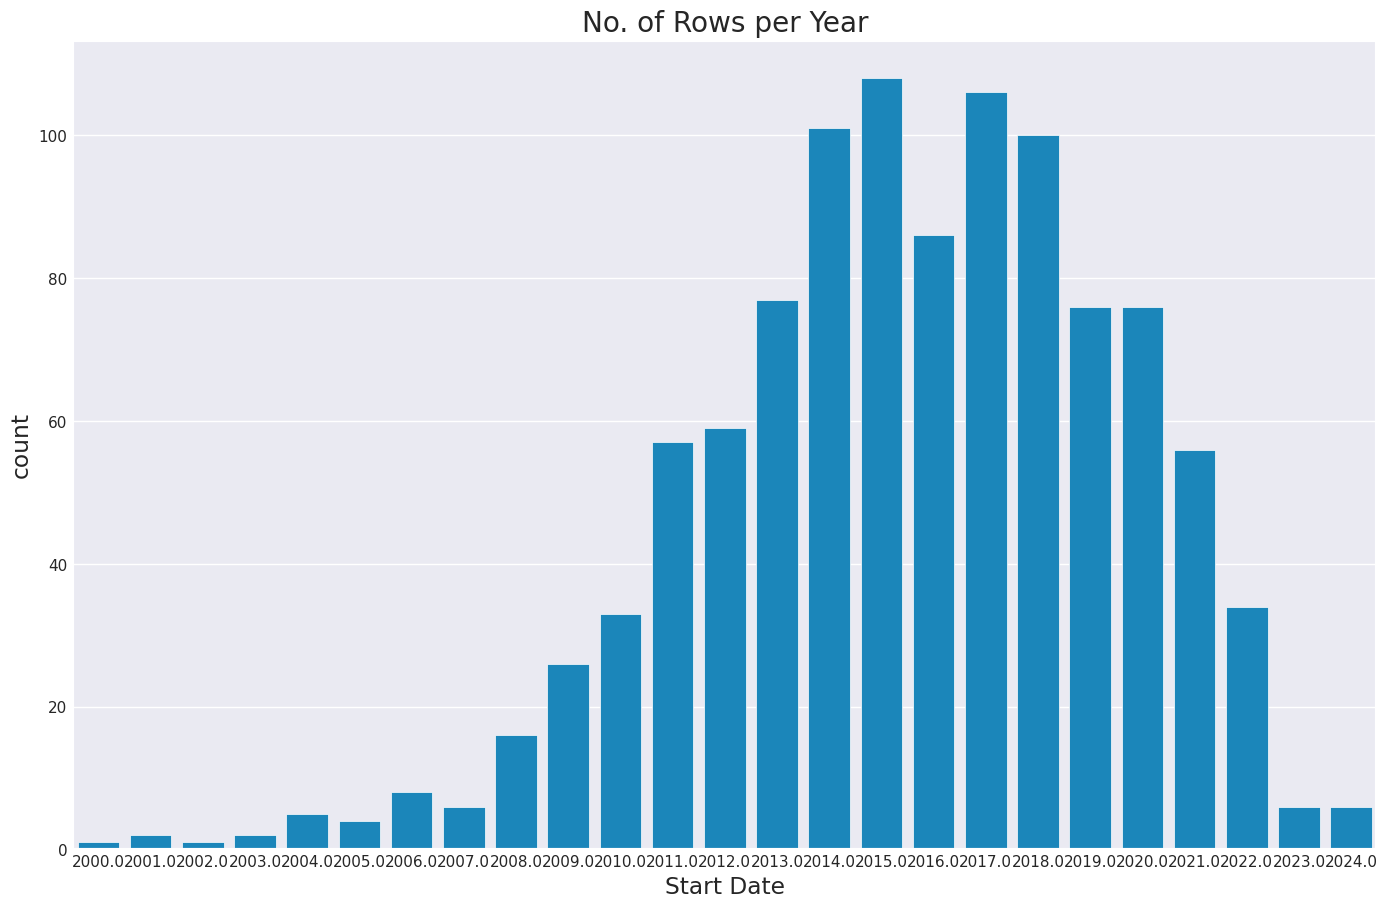

In [ ]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(train_df["Start Date"]).dt.year);

In [ ]:
year = pd.to_datetime(train_df["Start Date"]).dt.year
# year = year.astype(int)
# train_df["year"] = year
raw_df = train_df.copy()
train_df = raw_df[year < 2020]
val_df = raw_df[year >= 2020]

In [ ]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)


train_df.shape : (874, 30)
val_df.shape : (178, 30)


In [ ]:
year.value_counts().sort_index()

,count
Start Date,
2000.0,1
2001.0,2
2002.0,1
2003.0,2
2004.0,5
2005.0,4
2006.0,8
2007.0,6
2008.0,16


## Identifying Input and Target Columns

In [ ]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'Outcome'

In [ ]:
input_cols

['Study Title',
 'Study URL',
 'Acronym',
 'Study Status',
 'Brief Summary',
 'Study Results',
 'Conditions',
 'Interventions',
 'Primary Outcome Measures',
 'Secondary Outcome Measures',
 'Other Outcome Measures',
 'Sponsor',
 'Collaborators',
 'Sex',
 'Age',
 'Phases',
 'Enrollment',
 'Funder Type',
 'Study Type',
 'Study Design',
 'Start Date',
 'Primary Completion Date',
 'Completion Date',
 'First Posted',
 'Results First Posted',
 'Last Update Posted',
 'Locations',
 'Study Documents']

**We can now create inputs and targets for the training, validation and test sets for further processing and model training.**

In [ ]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy().map({"Approved": 1, "Failed": 0})

In [ ]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy().map({"Approved": 1, "Failed": 0})

In [ ]:
train_inputs.head(2)

,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,...,Study Type,Study Design,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents
0,A Global Study to Assess the Effects of MEDI47...,https://clinicaltrials.gov/study/NCT02125461,PACIFIC,COMPLETED,A Global Study to Assess the Effects of MEDI47...,YES,Non-Small Cell Lung Cancer,DRUG: MEDI4736|OTHER: PLACEBO,Progression Free Survival Based on Blinded Ind...,Objective Response Rate (ORR) Based on BICR As...,...,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,05-07-14,02-13-17,08-24-23,04-29-14,01-30-19,10-10-23,"Research Site, Chandler, Arizona, 85224, Unite...","Study Protocol, https://cdn.clinicaltrials.gov..."
1,A Study to Compare BMS-936558 to the Physician...,https://clinicaltrials.gov/study/NCT01721746,NaN,COMPLETED,The purpose of the study is to estimate the re...,YES,Unresectable or Metastatic Melanoma,BIOLOGICAL: BMS-936558|DRUG: Dacarbazine|DRUG:...,"Objective Response Rate (ORR), Objective respo...","Progression Free Survival (PFS), Progression F...",...,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,12-21-12,02-16-16,12-29-20,11-06-12,03-22-17,04-19-22,"Mayo Clinic, Phoenix, Arizona, 85054, United S...",NaN


In [ ]:
train_targets

,Outcome
0,1
1,1
2,1
3,0
4,1
...,...
1047,0
1049,0
1050,1
1051,1


**Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers**

In [ ]:
import numpy as np

In [ ]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [ ]:
train_inputs[numeric_cols].describe()

,Enrollment
count,873.000000
mean,577.373425
std,461.157725
min,1.000000
25%,295.000000
50%,480.000000
75%,748.000000
max,4509.000000


In [ ]:
train_inputs[categorical_cols].nunique().sort_values()

,0
Study Type,1
Study Results,2
Sex,3
Phases,3
Funder Type,4
Study Status,6
Age,6
Study Design,29
Other Outcome Measures,62
Collaborators,121


We will only one hot encode columns where cardinality is less than 10 above that we can look for feature engineering.

In [ ]:
categorical_cols = [col for col in train_inputs.select_dtypes(include='object').columns if 1 < train_inputs[col].nunique() < 10]


In [ ]:
categorical_cols

['Study Status', 'Study Results', 'Sex', 'Age', 'Phases', 'Funder Type']

## Imputing Missing Numeric Data

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value in the column using the SimpleImputer class from sklearn.impute.

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(strategy = 'median')

In [ ]:
train_inputs[numeric_cols].isna().sum()

,0
Enrollment,1


The first step in imputation is to fit the imputer to the data i.e. compute the chosen statistic (e.g. mean, median) for each column in the dataset.

In [ ]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer(strategy='median')

After calling fit, the computed statistic for each column is stored in the statistics_ property of imputer.

In [ ]:
list(imputer.statistics_)

[np.float64(457.0)]

The missing values in the training, test and validation sets can now be filled in using the transform method of imputer.

In [ ]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])

## Scaling Numeric Features

In [ ]:
raw_df[numeric_cols].describe()

,Enrollment
count,1051.000000
mean,549.970504
std,454.162671
min,1.000000
25%,251.000000
50%,457.000000
75%,732.000000
max,4509.000000


Let's use MinMaxScaler from sklearn.preprocessing to scale values to the  (0,1)  range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

First, we fit the scaler to the data i.e. compute the range of values for each numeric column.

In [ ]:
scaler.fit(raw_df[numeric_cols])

MinMaxScaler()

We can now inspect the minimum and maximum values in each column.

In [ ]:
print('Minimum:')
list(scaler.data_min_)

Minimum:


[np.float64(1.0)]

In [ ]:
print('Maximum:')
list(scaler.data_max_)

Maximum:


[np.float64(4509.0)]

We can now separately scale the training, validation and test sets using the transform method of scaler.

In [ ]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [ ]:
train_inputs[numeric_cols].describe()

,Enrollment
count,874.000000
mean,0.127825
std,0.102243
min,0.000000
25%,0.065217
50%,0.106145
75%,0.165705
max,1.000000


## Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

In [ ]:
raw_df[categorical_cols].nunique()

,0
Study Status,8
Study Results,2
Sex,3
Age,6
Phases,3
Funder Type,4


We can perform one hot encoding using the OneHotEncoder class from sklearn.preprocessing.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

First, we fit the encoder to the data i.e. identify the full list of categories across all categorical columns.

In [ ]:
encoder.fit(raw_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [ ]:
encoder.categories_

[array(['ACTIVE_NOT_RECRUITING', 'COMPLETED', 'ENROLLING_BY_INVITATION',
        'NOT_YET_RECRUITING', 'RECRUITING', 'SUSPENDED', 'TERMINATED',
        'UNKNOWN'], dtype=object),
 array(['NO', 'YES'], dtype=object),
 array(['ALL', 'FEMALE', 'MALE', nan], dtype=object),
 array(['ADULT', 'ADULT, OLDER_ADULT', 'CHILD', 'CHILD, ADULT',
        'CHILD, ADULT, OLDER_ADULT', 'OLDER_ADULT'], dtype=object),
 array(['PHASE2', 'PHASE2|PHASE3', 'PHASE3'], dtype=object),
 array(['INDUSTRY', 'NETWORK', 'NIH', 'OTHER'], dtype=object)]

The encoder has created a list of categories for each of the categorical columns in the dataset.
We can generate column names for each individual category using get_feature_names_out.

In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Study Status_ACTIVE_NOT_RECRUITING', 'Study Status_COMPLETED', 'Study Status_ENROLLING_BY_INVITATION', 'Study Status_NOT_YET_RECRUITING', 'Study Status_RECRUITING', 'Study Status_SUSPENDED', 'Study Status_TERMINATED', 'Study Status_UNKNOWN', 'Study Results_NO', 'Study Results_YES', 'Sex_ALL', 'Sex_FEMALE', 'Sex_MALE', 'Sex_nan', 'Age_ADULT', 'Age_ADULT, OLDER_ADULT', 'Age_CHILD', 'Age_CHILD, ADULT', 'Age_CHILD, ADULT, OLDER_ADULT', 'Age_OLDER_ADULT', 'Phases_PHASE2', 'Phases_PHASE2|PHASE3', 'Phases_PHASE3', 'Funder Type_INDUSTRY', 'Funder Type_NETWORK', 'Funder Type_NIH', 'Funder Type_OTHER']


All of the above columns will be added to train_inputs, val_inputs and test_inputs.

To perform the encoding, we use the transform method of encoder.

In [ ]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [ ]:
pd.set_option('display.max_columns', None)


In [ ]:
val_inputs.head(2)

,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sponsor,Collaborators,Sex,Age,Phases,Enrollment,Funder Type,Study Type,Study Design,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,Study Status_ACTIVE_NOT_RECRUITING,Study Status_COMPLETED,Study Status_ENROLLING_BY_INVITATION,Study Status_NOT_YET_RECRUITING,Study Status_RECRUITING,Study Status_SUSPENDED,Study Status_TERMINATED,Study Status_UNKNOWN,Study Results_NO,Study Results_YES,Sex_ALL,Sex_FEMALE,Sex_MALE,Sex_nan,Age_ADULT,"Age_ADULT, OLDER_ADULT",Age_CHILD,"Age_CHILD, ADULT","Age_CHILD, ADULT, OLDER_ADULT",Age_OLDER_ADULT,Phases_PHASE2,Phases_PHASE2|PHASE3,Phases_PHASE3,Funder Type_INDUSTRY,Funder Type_NETWORK,Funder Type_NIH,Funder Type_OTHER
13,"Study to Compare AMG 510 ""Proposed INN Sotoras...",https://clinicaltrials.gov/study/NCT04303780,NaN,ACTIVE_NOT_RECRUITING,A Phase 3 Study to Compare AMG 510 with Doceta...,YES,"KRAS p, G12c Mutated /Advanced Metastatic NSCLC",DRUG: AMG 510|DRUG: Docetaxel,"Progression-free Survival (PFS), PFS was defin...",NaN,NaN,Amgen,NaN,ALL,"ADULT, OLDER_ADULT",PHASE3,0.076309,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,06-04-20,08-02-22,04-27-26,03-11-20,05-10-23,02-25-25,"Pacific Cancer Medical Center Inc, Anaheim, Ca...","Study Protocol, https://cdn.clinicaltrials.gov...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
20,A Study to Assess if BIIB122 Tablets Are Safe ...,https://clinicaltrials.gov/study/NCT05418673,LIGHTHOUSE,TERMINATED,"In this study, researchers will learn more abo...",YES,Parkinson Disease,DRUG: BIIB122|DRUG: BIIB122-Matching Placebo,Time to Confirmed Worsening in Movement Disord...,Number of Participants With Treatment-Emergent...,NaN,Biogen,Denali Therapeutics Inc.,ALL,"ADULT, OLDER_ADULT",PHASE3,0.001331,INDUSTRY,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,08-26-22,07-27-23,07-27-23,06-14-22,06-26-24,06-26-24,"University of California San Francisco (UCSF),...","Study Protocol and Statistical Analysis Plan, ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Training and Visualization

This is a **binary classification** to **regression translation:**

We have **binary labels** (Approved = 1, Failed = 0)

But the real-world task is to estimate the probability of success for unseen trials — which can be interpreted as a PTS score
> In simpler terms:

Train a classifier → Use predicted probabilities as PTS %.

**1. Convert outcome to numeric**


```
full_df['outcome'] = full_df['outcome'].map({'Approved': 1, 'Failed': 0})
```



**2. Train a classifier (e.g., LightGBMClassifier)**
Use binary classification

Predict probability of class 1 (success) → that’s your PTS %


```
PTS % = model.predict_proba(test_X)[:, 1] * 100
```



In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score

# 1. Preprocess for classification
def preprocess_for_classification(df, date_col='start_date'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', format='mixed')
    df['year'] = df[date_col].dt.year
    df = df.dropna(subset=[date_col])

    df['outcome'] = df['outcome'].map({'Approved': 1, 'Failed': 0})  # binary target

    for col in df.select_dtypes(include='object').columns:
        if col != date_col:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df


# 2. Train classifier
def train_classifier(train_df, val_df, target_col='outcome'):
    features = [col for col in train_df.columns if col not in [target_col, 'start_date', 'year']]
    train_X, val_X = train_df[features], val_df[features]
    train_y, val_y = train_df[target_col], val_df[target_col]

    clf = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05)
    clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=50, verbose=100)

    return clf, features


# 3. Evaluate (optional)
def evaluate_classifier(clf, df, features, label='Validation'):
    probs = clf.predict_proba(df[features])[:, 1]
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(df['outcome'], preds)
    auc = roc_auc_score(df['outcome'], probs)
    print(f'{label} Accuracy: {acc:.4f}, AUC: {auc:.4f}')
    return probs


# 4. Run entire pipeline
def run_pts_prediction_pipeline(train_df, test_df, date_col='start_date'):
    print("✅ Preprocessing...")
    train_df = preprocess_for_classification(train_df, date_col)
    test_df  = preprocess_for_classification(test_df, date_col)

    print("✅ Splitting...")
    train_set, val_set = train_test_split(train_df, test_size=0.2, stratify=train_df['outcome'], random_state=42)

    print("✅ Training classifier...")
    clf, features = train_classifier(train_set, val_set)

    print("✅ Evaluating on validation set...")
    evaluate_classifier(clf, val_set, features)

    print("✅ Predicting on test set...")
    test_probs = clf.predict_proba(test_df[features])[:, 1]
    test_df['pts_percent'] = test_probs * 100

    return clf, test_df[['pts_percent']]


## Training

### Training a Logistic Regression Model

### Baseline model

In [ ]:
# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import lightgbm as lgb

In [ ]:
def create_baseline_model(X_train: pd.DataFrame, y_train: pd.Series):
    """Create a simple baseline model"""
    print("Creating baseline model...")

    # Simple Logistic Regression
    baseline_model = LogisticRegression(random_state=42, max_iter=1000)
    baseline_model.fit(X_train, y_train)

    # Cross-validation
    cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='roc_auc')

    results = {
        'model': baseline_model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }

    print(f"Baseline Model - CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return results

In [ ]:
cols_to_drop = ['Study Title',
 'Study URL',
 'Acronym',
 'Study Status',
 'Brief Summary',
 'Study Results',
 'Conditions',
 'Interventions',
 'Primary Outcome Measures',
 'Secondary Outcome Measures',
 'Other Outcome Measures',
 'Sponsor',
 'Collaborators',
 'Sex',
 'Age',
 'Phases',
 'Funder Type',
 'Study Type',
 'Study Design',
 'Start Date',
 'Primary Completion Date',
 'Completion Date',
 'First Posted',
 'Results First Posted',
 'Last Update Posted',
 'Locations',
 'Study Documents']
train_inputs = train_inputs.drop(columns=cols_to_drop)
val_inputs = val_inputs.drop(columns=cols_to_drop)


In [ ]:
train_inputs.head(2)

,Enrollment,Study Status_ACTIVE_NOT_RECRUITING,Study Status_COMPLETED,Study Status_ENROLLING_BY_INVITATION,Study Status_NOT_YET_RECRUITING,Study Status_RECRUITING,Study Status_SUSPENDED,Study Status_TERMINATED,Study Status_UNKNOWN,Study Results_NO,Study Results_YES,Sex_ALL,Sex_FEMALE,Sex_MALE,Sex_nan,Age_ADULT,"Age_ADULT, OLDER_ADULT",Age_CHILD,"Age_CHILD, ADULT","Age_CHILD, ADULT, OLDER_ADULT",Age_OLDER_ADULT,Phases_PHASE2,Phases_PHASE2|PHASE3,Phases_PHASE3,Funder Type_INDUSTRY,Funder Type_NETWORK,Funder Type_NIH,Funder Type_OTHER
0,0.157941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.089618,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
res = create_baseline_model(train_inputs, train_targets)

Creating baseline model...
Baseline Model - CV AUC: 0.7455 (+/- 0.0785)


In [ ]:
res

{'model': LogisticRegression(max_iter=1000, random_state=42),
 'cv_mean': np.float64(0.8329218106995885),
 'cv_std': np.float64(0.08421948601558106),
 'cv_scores': array([0.82304527, 0.93004115, 0.85596708, 0.87606838, 0.67948718])}

In [ ]:
res = create_baseline_model(val_inputs, val_targets)

Creating baseline model...
Baseline Model - CV AUC: 0.8329 (+/- 0.1684)


## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
train_preds = model.predict(X_train)

In [ ]:
train_preds

In [ ]:
train_probs = model.predict_proba(X_train)

In [ ]:
accuracy_score(train_targets, train_preds)

In [ ]:
model.score(X_val, val_targets)

In [ ]:
val_targets.value_counts() / len(val_targets)

## Feature importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [ ]:
model.feature_importances_

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# Advance Techniques

### Advanced Models

In [ ]:
def train_advanced_models(X_train: pd.DataFrame, y_train: pd.Series):
        """Train multiple advanced models"""
        print("Training advanced models...")

        models = {}

        # Random Forest
        rf_model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train, y_train)
        rf_cv = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
        models['RandomForest'] = {
            'model': rf_model,
            'cv_mean': rf_cv.mean(),
            'cv_std': rf_cv.std()
        }

        # XGBoost
        xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train, y_train)
        xgb_cv = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
        models['XGBoost'] = {
            'model': xgb_model,
            'cv_mean': xgb_cv.mean(),
            'cv_std': xgb_cv.std()
        }

        # # LightGBM
        # lgb_model = lgb.LGBMClassifier(
        #     n_estimators=200,
        #     max_depth=6,
        #     learning_rate=0.1,
        #     subsample=0.8,
        #     colsample_bytree=0.8,
        #     random_state=42,
        #     verbose=-1
        # )
        # lgb_model.fit(X_train, y_train)
        # lgb_cv = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='roc_auc')
        # models['LightGBM'] = {
        #     'model': lgb_model,
        #     'cv_mean': lgb_cv.mean(),
        #     'cv_std': lgb_cv.std()
        # }

        # Gradient Boosting
        gb_model = GradientBoostingClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
        gb_model.fit(X_train, y_train)
        gb_cv = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='roc_auc')
        models['GradientBoosting'] = {
            'model': gb_model,
            'cv_mean': gb_cv.mean(),
            'cv_std': gb_cv.std()
        }

        # Print results
        for name, result in models.items():
            print(f"{name} - CV AUC: {result['cv_mean']:.4f} (+/- {result['cv_std'] * 2:.4f})")

        return models

In [ ]:
#modified
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import pandas as pd
import numpy as np

def train_advanced_models(X_train: pd.DataFrame, y_train: pd.Series):
    """Train and tune advanced models, then show feature importances."""
    print("Training and tuning advanced models...")

    models = {}

    # Helper to display feature importances
    def show_feature_importance(model, model_name):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_df = pd.DataFrame({
                'feature': X_train.columns,
                'importance': importances
            }).sort_values(by='importance', ascending=False)
            print(f"\n{model_name} - Top Feature Importances:")
            print(importance_df.head(10))
            return importance_df
        return None

    # -------------------
    # Random Forest
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=10, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
    rf_search.fit(X_train, y_train)
    best_rf = rf_search.best_estimator_
    rf_cv = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')
    models['RandomForest'] = {
        'model': best_rf,
        'cv_mean': rf_cv.mean(),
        'cv_std': rf_cv.std(),
        'feature_importance': show_feature_importance(best_rf, "RandomForest")
    }

    # -------------------
    # XGBoost
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    xgb_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=10, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
    xgb_search.fit(X_train, y_train)
    best_xgb = xgb_search.best_estimator_
    xgb_cv = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='roc_auc')
    models['XGBoost'] = {
        'model': best_xgb,
        'cv_mean': xgb_cv.mean(),
        'cv_std': xgb_cv.std(),
        'feature_importance': show_feature_importance(best_xgb, "XGBoost")
    }

    # -------------------
    # Gradient Boosting
    gb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_search = RandomizedSearchCV(gb_model, gb_param_grid, n_iter=10, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
    gb_search.fit(X_train, y_train)
    best_gb = gb_search.best_estimator_
    gb_cv = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='roc_auc')
    models['GradientBoosting'] = {
        'model': best_gb,
        'cv_mean': gb_cv.mean(),
        'cv_std': gb_cv.std(),
        'feature_importance': show_feature_importance(best_gb, "GradientBoosting")
    }

    # -------------------
    # Print Summary
    print("\nModel Performance Summary (Tuned Models):")
    for name, result in models.items():
        print(f"{name} - CV AUC: {result['cv_mean']:.4f} (+/- {result['cv_std'] * 2:.4f})")

    return models


In [ ]:
advanced_models = train_advanced_models(train_inputs, train_targets)

Training and tuning advanced models...

RandomForest - Top Feature Importances:
                               feature  importance
7              Study Status_TERMINATED    0.276987
0                           Enrollment    0.127903
1   Study Status_ACTIVE_NOT_RECRUITING    0.117354
10                   Study Results_YES    0.091656
2               Study Status_COMPLETED    0.085397
9                     Study Results_NO    0.082809
16              Age_ADULT, OLDER_ADULT    0.059521
17                           Age_CHILD    0.034295
24                Funder Type_INDUSTRY    0.020856
11                             Sex_ALL    0.019275

XGBoost - Top Feature Importances:
                               feature  importance
7              Study Status_TERMINATED    0.347735
9                     Study Results_NO    0.118174
2               Study Status_COMPLETED    0.094080
10                   Study Results_YES    0.082226
1   Study Status_ACTIVE_NOT_RECRUITING    0.064263
12               

| Feature                             | Importance Rank  | Notes                                                                        |
| ----------------------------------- | ---------------- | ---------------------------------------------------------------------------- |
| `Study Status_TERMINATED`           | #1 in all models | Strong signal, likely associated with outcome label. Might cause overfitting                         |
| `Enrollment`                        | #2 (RF & GB)     | Expected — higher/lower enrollment may indicate study scale or quality.      |
| `Study Status_*` (active/completed) | Top 5            | Study phase clearly matters.                                                 |
| `Study Results_YES/NO`              | Top 10           | Logical driver — whether results exist may signal study outcome or maturity. |
| `Age_*` groups                      | Mid-ranked       | Could relate to target population diversity or difficulty.                   |
| `Sex_ALL`, `Sex_FEMALE`             | Lower top-10     | Some demographic signal, but weaker.                                         |


### Stacking models

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def stack_models(X_train: pd.DataFrame, y_train: pd.Series, base_models: dict):
    """
    Create and evaluate a stacking classifier using the tuned base models.

    Parameters:
        X_train: pd.DataFrame — training features
        y_train: pd.Series — training labels
        base_models: dict — models returned from train_advanced_models()

    Returns:
        dict — stacked model and performance
    """
    print("\n🔀 Stacking base models...")

    # Build the estimators list for StackingClassifier
    estimators = [
        ('rf', base_models['RandomForest']['model']),
        ('xgb', base_models['XGBoost']['model']),
        ('gb', base_models['GradientBoosting']['model'])
    ]

    # Use Logistic Regression as meta-model
    meta_model = LogisticRegression(max_iter=1000, random_state=42)

    stack_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1,
        passthrough=True  # allows meta-model to see raw input features as well
    )

    stack_clf.fit(X_train, y_train)
    stack_cv = cross_val_score(stack_clf, X_train, y_train, cv=5, scoring='roc_auc')

    print(f"\n🧱 Stacked Model - CV AUC: {stack_cv.mean():.4f} (+/- {stack_cv.std() * 2:.4f})")

    return {
        'model': stack_clf,
        'cv_mean': stack_cv.mean(),
        'cv_std': stack_cv.std()
    }


In [ ]:
# Stacking
stacked = stack_models(train_inputs, train_targets, advanced_models)


🔀 Stacking base models...

🧱 Stacked Model - CV AUC: 0.7466 (+/- 0.0623)


### Interpretability

In [ ]:
import shap
import matplotlib.pyplot as plt

def explain_model_with_shap(model, X_sample: pd.DataFrame, model_name: str = "Model"):
    """
    Generate SHAP summary plots for a tree-based model.

    Parameters:
        model: Trained tree-based model (e.g., RandomForest, XGBoost, etc.)
        X_sample: pd.DataFrame — sample of input features
        model_name: str — label for display
    """
    print(f"\n🔎 Generating SHAP explanations for {model_name}...")

    # Use TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    # Handle shap_values for classification models
    if isinstance(shap_values, list) and len(shap_values) == 2:
        # Binary classification — take class 1's SHAP values
        shap_values_to_use = shap_values[1]
    else:
        shap_values_to_use = shap_values

    # Plot: Bar plot of mean absolute SHAP values
    print(f"📊 Summary plot (bar) for {model_name}")
    shap.summary_plot(shap_values_to_use, X_sample, plot_type="bar", max_display=10)

    # Plot: Beeswarm plot
    print(f"🌪️ Summary plot (beeswarm) for {model_name}")
    shap.summary_plot(shap_values_to_use, X_sample, max_display=10)



🔎 Generating SHAP explanations for RandomForest...
📊 Summary plot (bar) for RandomForest


<Figure size 1500x1000 with 0 Axes>

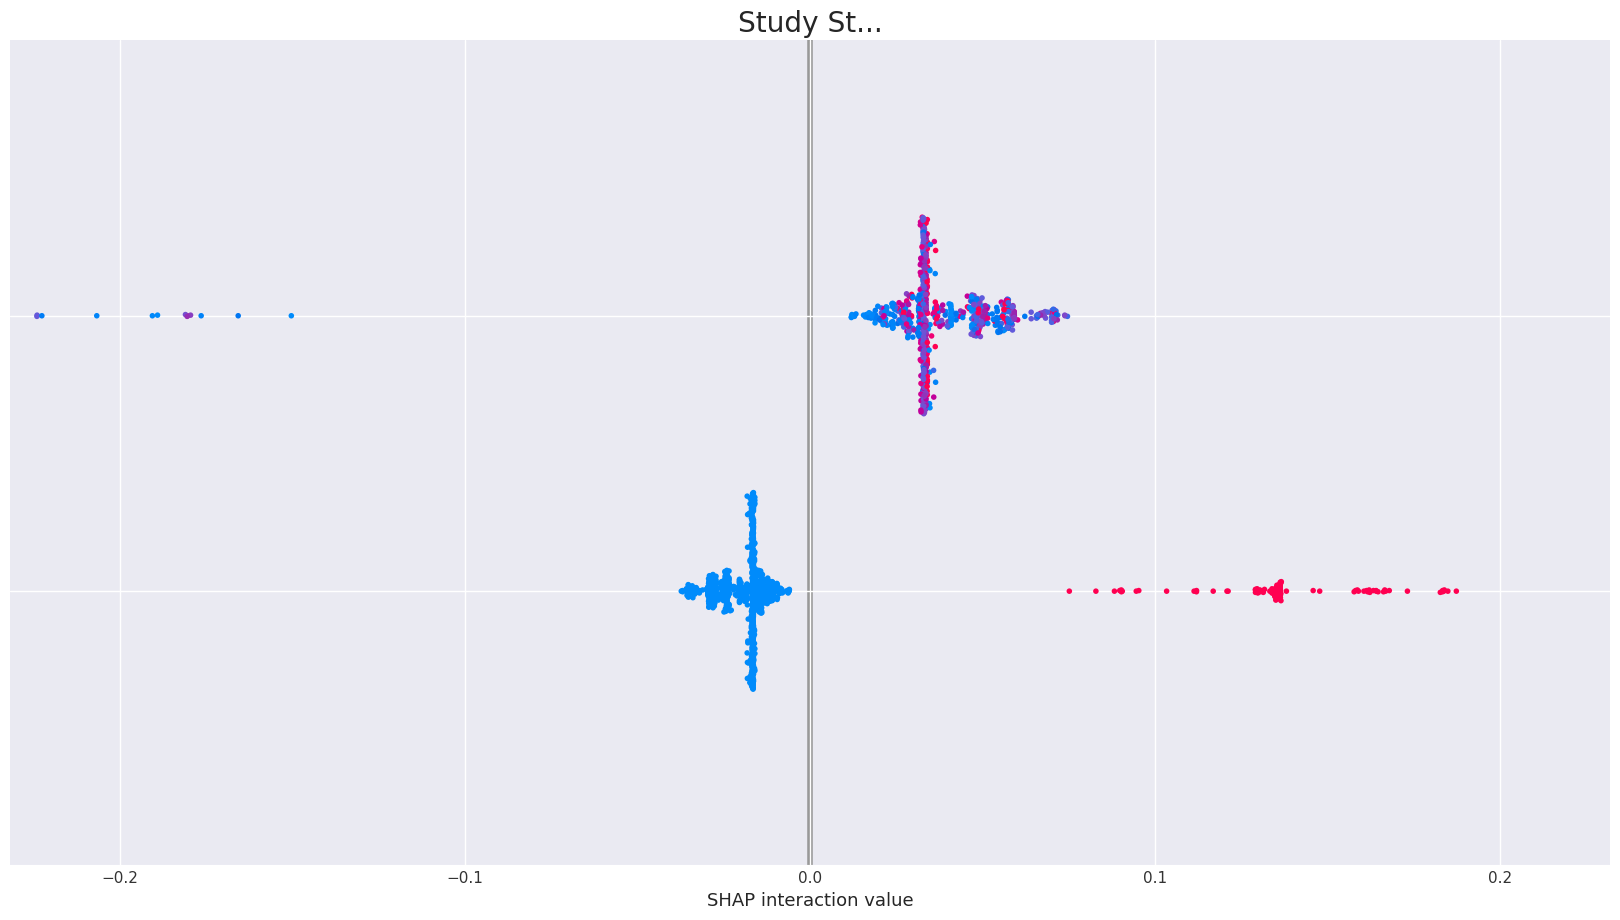

🌪️ Summary plot (beeswarm) for RandomForest


<Figure size 1500x1000 with 0 Axes>

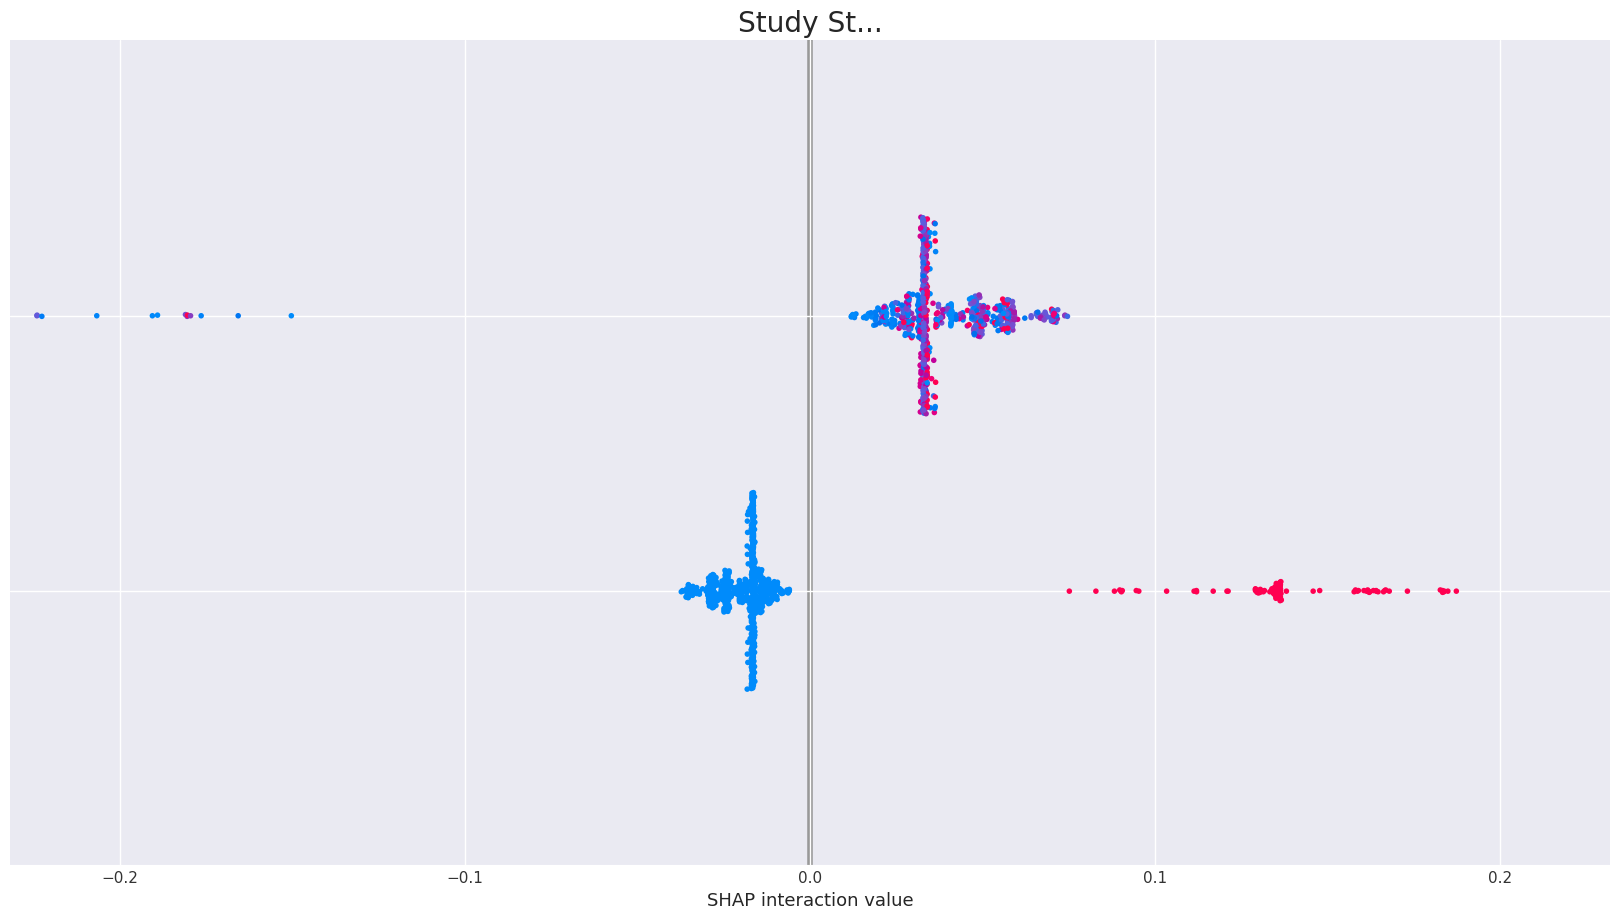

In [ ]:
# SHAP interpretability on best base model
explain_model_with_shap(
    model=advanced_models['RandomForest']['model'],
    X_sample=train_inputs,
    model_name="RandomForest"
)
